# Untargeted Adversarial Attack with Incomplete MNIST

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, BatchNormalization, Dropout, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import itertools
import seaborn as sns
import pickle

## Deep Convolutional Network for MNIST


In [2]:
mpl.rcParams['figure.figsize'] = (4, 4)
mpl.rcParams['axes.grid'] = False
path = '/content/drive/MyDrive/Work/Baylor/Research/ad_ex_incomplete/' #your directory's path
learning_rate = 0.01
batch_size = 2000
epochs = 50

In [3]:
def predict_class(model, input):
  pred = model.predict(input)
  class_pred = []
  for i in pred:
    ans = tf.argmax(i)
    class_pred.append(ans)
  return tf.convert_to_tensor(class_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
opt = Adam(learning_rate=learning_rate)

input = Input(shape=(28,28,1))
conv1 = Conv2D(32,kernel_size=3,activation='relu')(input)
batch1 = BatchNormalization()(conv1)
conv2 = Conv2D(32,kernel_size=3,activation='relu')(batch1)
batch2 = BatchNormalization()(conv2)
conv3 = Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu')(batch2)
batch3 = BatchNormalization()(conv3)
drop1 = Dropout(0.4)(batch3)

conv4 = Conv2D(64,kernel_size=3,activation='relu')(drop1)
batch4 = BatchNormalization()(conv4)
conv5 = Conv2D(64,kernel_size=3,activation='relu')(batch4)
batch5 = BatchNormalization()(conv5)
conv6 = Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu')(batch5)
batch6 = BatchNormalization()(conv6)
drop2 = Dropout(0.4)(batch6)

flat1 = Flatten()(drop2)
dense1 = Dense(128, activation='relu')(flat1)
batch7 = BatchNormalization()(dense1)
drop3 = Dropout(0.4)(batch7)
dense2 = Dense(10)(drop3)
output = Softmax()(dense2)

z_mnist_classifier = Model(input, dense2, name='z_mnist_classifier')

mnist_classifier = Model(input, output, name='mnist_classifier')

z_mnist_classifier.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
mnist_classifier.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = tf.reshape(x_train,(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = tf.reshape(x_test,(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_train = x_train/255
x_test = x_test/255
y_train_oh = tf.one_hot(y_train, 10)
y_test_oh = tf.one_hot(y_test, 10)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10,  
                              min_delta=1e-4, mode='min')

stop_alg = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

#Cross validation training
n_trains = x_train.shape[0]
n_val = 5
n_sub_trains = n_trains // n_val
x_cross_val = []
y_cross_val = []
for i in range(n_val):
  x_cross_val.append(x_train[i*n_sub_trains:(i+1)*n_sub_trains])
  y_cross_val.append(y_train_oh[i*n_sub_trains:(i+1)*n_sub_trains])
for i in range(epochs):
  print('Epoch: ' + str(i+1))
  x_train_turn = []
  y_train_turn = []
  for j in range(n_val):
    if (j != i%n_val):
      if (len(x_train_turn) == 0):
        x_train_turn = x_cross_val[j]
        y_train_turn = y_cross_val[j]
      else:
        x_train_turn = tf.concat([x_train_turn, x_cross_val[j]], axis = 0)
        y_train_turn = tf.concat([y_train_turn, y_cross_val[j]], axis = 0)
  x_val = x_cross_val[i%n_val]
  y_val = y_cross_val[i%n_val]
  mnist_classifier.fit(x_train_turn,y_train_turn,batch_size=batch_size,validation_data=(x_val,y_val),
                     verbose=1,epochs=1, callbacks=[reduce_lr, stop_alg])
mnist_classifier.save_weights(path + 'mnist_weights')

Epoch: 1
24/24 [==============================] - 165s 7s/step - loss: 1.0871 - accuracy: 0.6869 - val_loss: 0.7604 - val_accuracy: 0.8656
Epoch: 2
24/24 [==============================] - 162s 7s/step - loss: 0.0984 - accuracy: 0.9708 - val_loss: 0.9427 - val_accuracy: 0.7910
Epoch: 3
24/24 [==============================] - 162s 7s/step - loss: 0.0665 - accuracy: 0.9801 - val_loss: 1.7894 - val_accuracy: 0.6134
Epoch: 4
24/24 [==============================] - 162s 7s/step - loss: 0.0522 - accuracy: 0.9841 - val_loss: 2.3701 - val_accuracy: 0.4267
Epoch: 5
24/24 [==============================] - 163s 7s/step - loss: 0.0440 - accuracy: 0.9867 - val_loss: 2.6294 - val_accuracy: 0.3350
Epoch: 6
24/24 [==============================] - 163s 7s/step - loss: 0.0387 - accuracy: 0.9878 - val_loss: 2.8682 - val_accuracy: 0.3392
Epoch: 7
24/24 [==============================] - 163s 7s/step - loss: 0.0359 - accuracy: 0.9888 - val_loss: 2.9703 - val_accuracy: 0.3293
Epoch: 8
24/24 [===========

In [6]:
mnist_classifier.load_weights(path+'mnist_weights')

In [ ]:
pred = mnist_classifier.predict(x_test)
cce = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
class_pred = predict_class(mnist_classifier, x_test)

Loss: 0.02
Accuracy: 99.39%
BER: 0.99


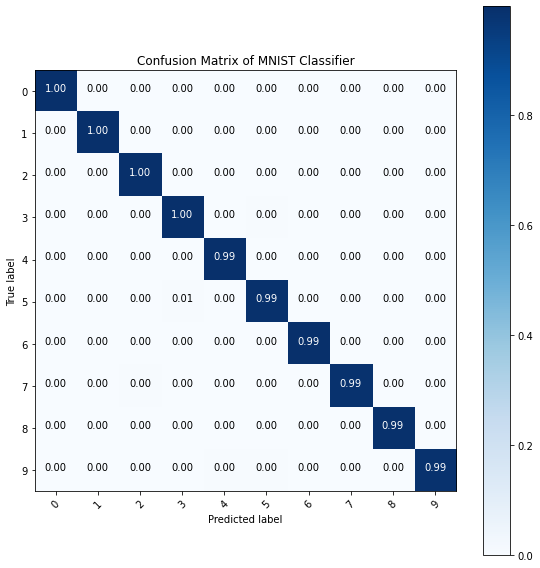

In [ ]:
print('Loss: {:.2f}'.format(cce(y_test_oh, pred).numpy()))
print('Accuracy: {:.2f}%'.format(metrics.accuracy_score(y_test, class_pred)*100))
print('BER: {:.2f}'.format(metrics.balanced_accuracy_score(y_test, class_pred)))
classes = ['0','1','2','3','4','5','6','7','8','9']
mpl.rcParams['figure.figsize'] = (8, 8)
plot_confusion_matrix(metrics.confusion_matrix(y_test, class_pred),classes,title='Confusion Matrix of MNIST Classifier',normalize=True)
mpl.rcParams['figure.figsize'] = (4, 4)

## Declare test number 4

In [7]:
inx_test = 198
image = x_test[inx_test]
w = 28
h = 28
ch = 1

correct_inx = y_test[inx_test]
image_probs = mnist_classifier.predict(tf.reshape(image, (1,h,w,ch)))
label = tf.one_hot(correct_inx, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

In [8]:
def get_class_confidence(input_image):
  input_image = tf.reshape(input_image, (1,h,w,ch))
  class_pred = predict_class(mnist_classifier, input_image)[0]
  conf = mnist_classifier.predict(input_image)[0][class_pred]
  return class_pred, conf

## Experiment

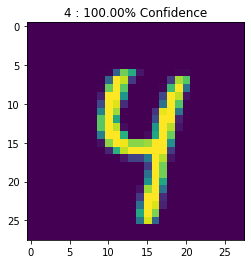

In [ ]:
plt.figure()
plt.imshow(tf.reshape(image,(28,28))) # To change [-1, 1] to [0,1]
image_class, class_confidence = get_class_confidence(image)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

### Define Attacks 

In [9]:
loss_object = tf.keras.losses.MeanSquaredError()

def get_max_and_index(input):
  max = 0
  inx_i = 0
  inx_j = 0
  inx_k = 0
  for i in range(h):
    for j in range(w):
      for k in range(ch):
        if (input[0][i][j][k] >= max):
          inx_i = i
          inx_j = j
          inx_k = k
          max = input[0][i][j][k]
  return max, inx_i, inx_j, inx_k

def convert_s_map(grad, inx_tgt, targeted=False):
  n_classes = len(grad)
  s = np.zeros((1,h,w,ch))
  for i in range(h):
    for j in range(w):
      for k in range(ch):
        sum = 0
        for t in range(n_classes):
          if (t != inx_tgt):
            sum += grad[t][i][j][k]
        if ((not targeted) and grad[inx_tgt][i][j][k] <= 0 and sum >= grad[inx_tgt][i][j][k]):
          s[0][i][j][k] = tf.abs(grad[inx_tgt][i][j][k]) * sum
        elif (targeted and grad[inx_tgt][i][j][k] >= 0 and sum <= 0):
          s[0][i][j][k] = grad[inx_tgt][i][j][k] * tf.abs(sum)
  return tf.cast(tf.convert_to_tensor(s), tf.float32)

def saliency_map(input_image, masked = None):
  if(masked == None):
    masked = tf.ones(input_image.shape)
  gradient = []
  n_classes = len(mnist_classifier.predict(input_image)[0])
  for i in range(n_classes):
    with tf.GradientTape() as tape:
      tape.watch(input_image)
      prediction = z_mnist_classifier(input_image) 
      pred_inx = prediction[0][i]
    gradient.append((tape.gradient(pred_inx, input_image)*masked)[0])
  return gradient
  
def fgsm(input_image, input_label, epsilon, masked=None, targeted=False):
  if(masked == None):
    masked = tf.ones(input_image.shape)
  input_image = tf.reshape(input_image, (1,h,w,ch))
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = mnist_classifier(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  if (not targeted):
    return tf.clip_by_value(tf.reshape(input_image + epsilon*signed_grad*masked, (h,w,ch)), 0,1)
  return tf.clip_by_value(tf.reshape(input_image - epsilon*signed_grad*masked, (h,w,ch)), 0,1)

def igsm(input_image, input_label, inx_tgt, max_iter, step_size, epsilon, masked=None, targeted=False):
  if(masked == None):
    masked = tf.ones(input_image.shape)
  input_image = tf.reshape(input_image, (1,h,w,ch))  
  adv = input_image
  i = 0
  if (not targeted):
    new_label = inx_tgt
  else:
    new_label, new_confidence = get_class_confidence(input_image)
  
  while(i < max_iter and (((not targeted) and new_label == inx_tgt) or (targeted and new_label != inx_tgt))):
    with tf.GradientTape() as tape:
      tape.watch(adv)
      prediction = mnist_classifier(adv)
      loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, adv)
    signed_grad = tf.sign(gradient)
    if (not targeted):
      adv = adv + step_size*signed_grad*masked
    else:
      adv = adv - step_size*signed_grad*masked
    adv = tf.clip_by_value(adv,input_image-epsilon,input_image+epsilon)
    adv = tf.clip_by_value(adv,0,1)
    new_label, new_confidence = get_class_confidence(adv)
    i += 1
  return tf.reshape(adv, (h,w,ch))

def jsma(input_image, inx_tgt, max_iter, step_size, masked=None, targeted=False):
  if(masked == None):
    masked = tf.ones(input_image.shape)
  input_image = tf.reshape(input_image, (1,h,w,ch))
  if (not targeted):
    new_label = inx_tgt
  else:
    new_label, new_confidence = get_class_confidence(input_image)
  adv = input_image
  altered = np.zeros(input_image.shape)
  count = 0
  while (np.sum(altered) <= 0.05*w*h*ch and count < max_iter and ((not targeted and new_label == inx_tgt) or (targeted and new_label != inx_tgt))):
    grad = saliency_map(adv, masked)
    s = convert_s_map(grad, inx_tgt, targeted=targeted)
    max, inx_i, inx_j, inx_k = get_max_and_index(s)
    if (max == 0):
      return tf.reshape(adv, (h,w,ch)), np.sum(altered)
    altered[0][inx_i][inx_j][inx_k] = 1
    tmp = np.zeros((1,h,w,ch))
    tmp[0][inx_i][inx_j][inx_k] = step_size
    tmp = tf.cast(tf.constant(tmp), tf.float32)
    adv = adv + tmp
    adv = tf.clip_by_value(adv,0,1)  

    if (adv[0][inx_i][inx_j][inx_k] == 0 or adv[0][inx_i][inx_j][inx_k] == 1):
      tmp = np.ones((1,h,w,ch))
      tmp[0][inx_i][inx_j][inx_k] = 0
      tmp = tf.constant(tmp)
      masked = masked * tf.cast(tmp,tf.float32)
    new_label, new_confidence = get_class_confidence(adv)
    #print(str(inx_i) + ", " + str(inx_j) + ", " + str(inx_k) + ", " + str(adv[0][inx_i][inx_j][inx_k]) + ", " + str(new_confidence) + " " + str(count) + ' ' + str(new_label))
    count += 1
  return tf.reshape(adv, (h,w,ch)), np.sum(altered)

def loss_for_cw(model, x, inx_tgt, targeted=False, conf=0):
  re_x = tf.reshape(x,(1,h,w,ch))
  pred = model(re_x)  
  max = -9999
  for i in range(pred.shape[1]):
    if (i != inx_tgt and pred[0][i] >= max):
      max = pred[0][i]
  if (targeted):
    return tf.maximum(max - pred[0][inx_tgt], conf)
  else:
    return tf.maximum(pred[0][inx_tgt] - max, conf)

def cw(input_image, inx_tgt, max_iter, step_size, masked=None, targeted=False):
  if(masked == None):
    masked = tf.ones(input_image.shape)
  if (not targeted):
    new_label = inx_tgt
  else:
    new_label, new_confidence = get_class_confidence(input_image)
  w_ = tf.atanh(input_image*2 - 1)
  c = 0.01
  loss1 = 15
  while ((((not targeted) and new_label == inx_tgt) or (targeted and new_label != inx_tgt)) and c <= 100):
    i = 0
    while (i < max_iter and (((not targeted) and new_label == inx_tgt) or (targeted and new_label != inx_tgt))):
      with tf.GradientTape() as tape:
        tape.watch(w_)
        adv = (tf.tanh(w_) + 1.0)/2.0
        adv = input_image + (adv - input_image)*masked
        loss1 = tf.norm((adv-input_image)*masked)        
        loss2 = loss_for_cw(z_mnist_classifier, adv, inx_tgt, targeted=targeted)
        loss = loss1 + c*loss2
      gradient = tape.gradient(loss, w_)
      w_ = w_ - step_size*gradient
      adv = (tf.tanh(w_) + 1.0)/2.0
      adv = input_image + (adv - input_image)*masked
      new_label, new_confidence = get_class_confidence(adv)
      #print('new label: {}, new confidence: {}, loss1: {}, loss2: {}'.format(new_label, new_confidence, loss1, loss2))
      i += 1
    c *= 2
  return adv, tf.norm(adv - input_image), c

### Experiment on number 4

In [10]:
def display_images(image, description):
  prediction = mnist_classifier.predict(tf.reshape(image, (1,h,w,ch)))
  label, confidence = get_class_confidence(image)  
  plt.figure()
  plt.imshow(tf.reshape(image,(28,28))) # To change [-1, 1] to [0,1]
  print('{} \n Pred={} : {:.2f}% Confidence \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100, correct_inx, prediction[0][correct_inx]*100))
  plt.show()

In [11]:
epsilons = []
i = 0
while (i <= 0.51):
  epsilons.append(i)
  i += 0.02
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]
conf_fgsm = []
conf_igsm = []
conf_jsma = []
conf_cw = []

conf_fgsm_top = []
conf_igsm_top = []
conf_jsma_top = []
conf_cw_top = []

conf_fgsm_bottom = []
conf_igsm_bottom = []
conf_jsma_bottom = []
conf_cw_bottom = []


other_conf_fgsm = []
other_conf_igsm = []
other_conf_jsma = []
other_conf_cw = []

other_conf_fgsm_top = []
other_conf_igsm_top = []
other_conf_jsma_top = []
other_conf_cw_top = []

other_conf_fgsm_bottom = []
other_conf_igsm_bottom = []
other_conf_jsma_bottom = []
other_conf_cw_bottom = []

#### Complete image



##### FGSM

Input 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


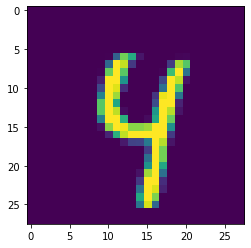

Epsilon = 0.020 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


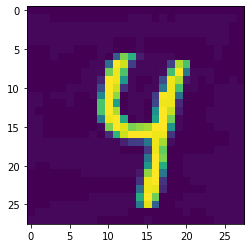

Epsilon = 0.040 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


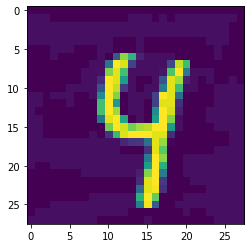

Epsilon = 0.060 
 Pred=4 : 99.80% Confidence 
 4 : 99.80% Confidence


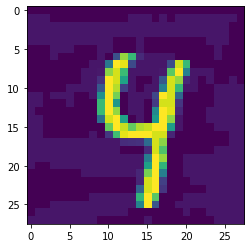

Epsilon = 0.080 
 Pred=4 : 90.26% Confidence 
 4 : 90.26% Confidence


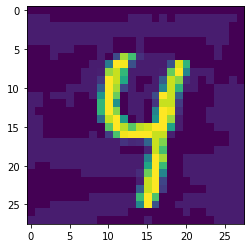

Epsilon = 0.100 
 Pred=9 : 84.16% Confidence 
 4 : 15.57% Confidence


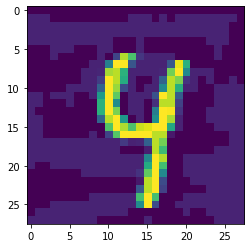

Epsilon = 0.120 
 Pred=9 : 98.45% Confidence 
 4 : 1.03% Confidence


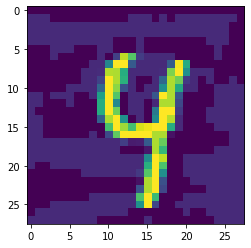

Epsilon = 0.140 
 Pred=9 : 98.94% Confidence 
 4 : 0.16% Confidence


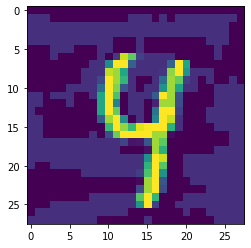

Epsilon = 0.160 
 Pred=9 : 98.40% Confidence 
 4 : 0.04% Confidence


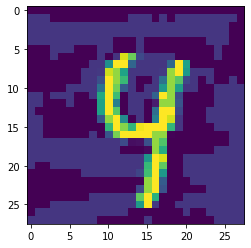

Epsilon = 0.180 
 Pred=9 : 97.07% Confidence 
 4 : 0.01% Confidence


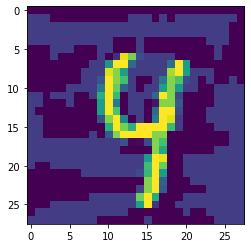

Epsilon = 0.200 
 Pred=9 : 93.97% Confidence 
 4 : 0.01% Confidence


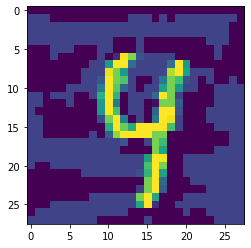

Epsilon = 0.220 
 Pred=9 : 85.15% Confidence 
 4 : 0.00% Confidence


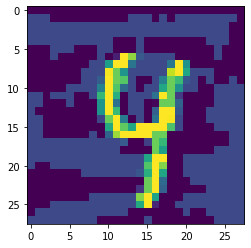

Epsilon = 0.240 
 Pred=9 : 66.97% Confidence 
 4 : 0.00% Confidence


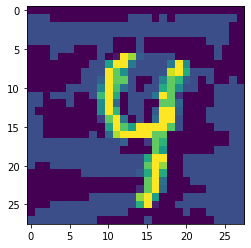

Epsilon = 0.260 
 Pred=8 : 54.63% Confidence 
 4 : 0.00% Confidence


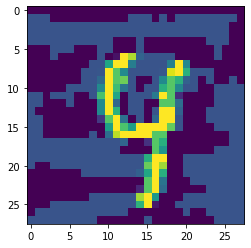

Epsilon = 0.280 
 Pred=8 : 78.32% Confidence 
 4 : 0.00% Confidence


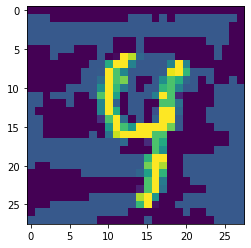

Epsilon = 0.300 
 Pred=8 : 92.41% Confidence 
 4 : 0.00% Confidence


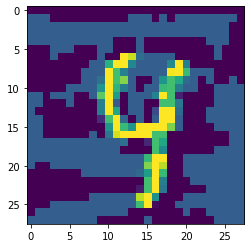

Epsilon = 0.320 
 Pred=8 : 97.93% Confidence 
 4 : 0.00% Confidence


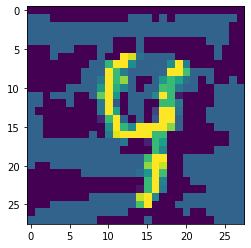

Epsilon = 0.340 
 Pred=8 : 99.41% Confidence 
 4 : 0.00% Confidence


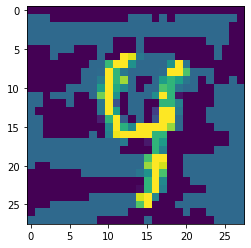

Epsilon = 0.360 
 Pred=8 : 99.82% Confidence 
 4 : 0.00% Confidence


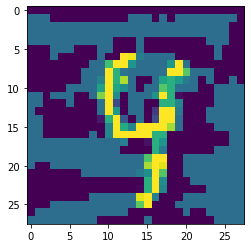

Epsilon = 0.380 
 Pred=8 : 99.94% Confidence 
 4 : 0.00% Confidence


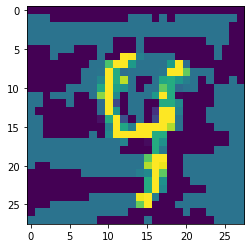

Epsilon = 0.400 
 Pred=8 : 99.98% Confidence 
 4 : 0.00% Confidence


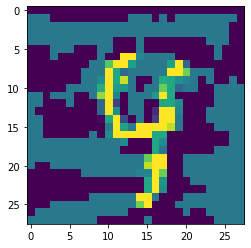

Epsilon = 0.420 
 Pred=8 : 99.99% Confidence 
 4 : 0.00% Confidence


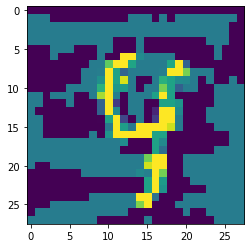

Epsilon = 0.440 
 Pred=8 : 99.99% Confidence 
 4 : 0.00% Confidence


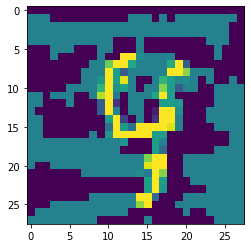

Epsilon = 0.460 
 Pred=8 : 100.00% Confidence 
 4 : 0.00% Confidence


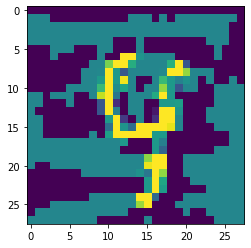

Epsilon = 0.480 
 Pred=8 : 100.00% Confidence 
 4 : 0.00% Confidence


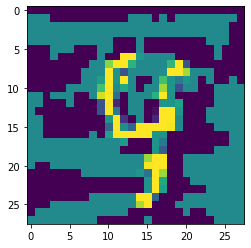

Epsilon = 0.500 
 Pred=8 : 100.00% Confidence 
 4 : 0.00% Confidence


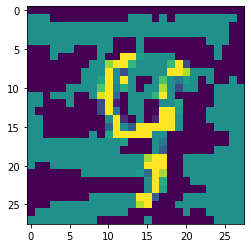

In [ ]:
for i, eps in enumerate(epsilons):
  adv = fgsm(image, label, eps)
  pred = mnist_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
  conf_fgsm.append(pred[0][correct_inx])
  max = 0
  for j in range(pred.shape[1]):
    if(j != correct_inx and pred[0][j] >= max):
      max = pred[0][j]
  other_conf_fgsm.append(max)
  display_images(adv, descriptions[i])

##### IGSM

Input 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


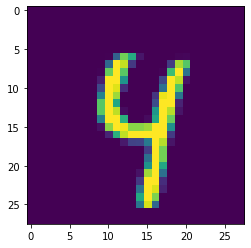

Epsilon = 0.020 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


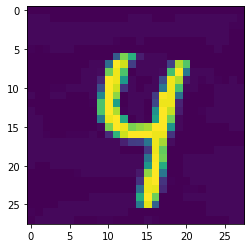

Epsilon = 0.040 
 Pred=4 : 99.99% Confidence 
 4 : 99.99% Confidence


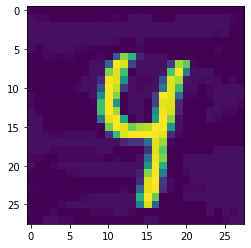

Epsilon = 0.060 
 Pred=4 : 99.79% Confidence 
 4 : 99.79% Confidence


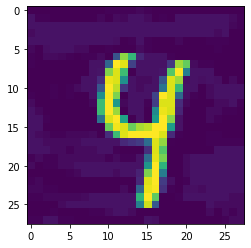

Epsilon = 0.080 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


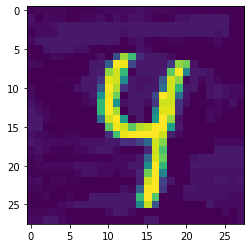

Epsilon = 0.100 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


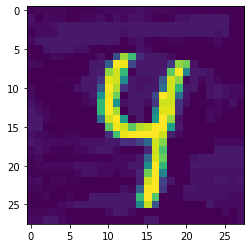

Epsilon = 0.120 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


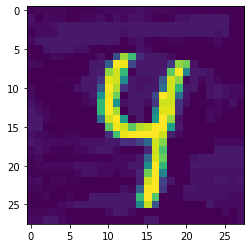

Epsilon = 0.140 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


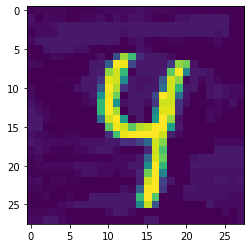

Epsilon = 0.160 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


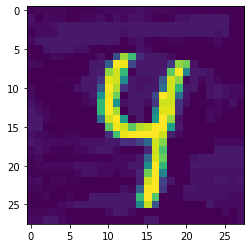

Epsilon = 0.180 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


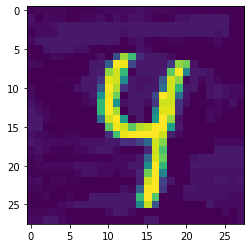

Epsilon = 0.200 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


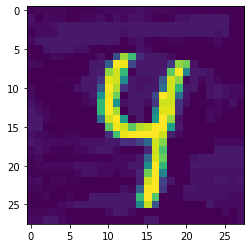

Epsilon = 0.220 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


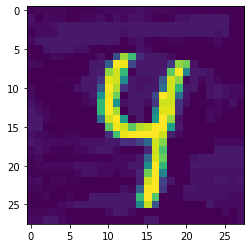

Epsilon = 0.240 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


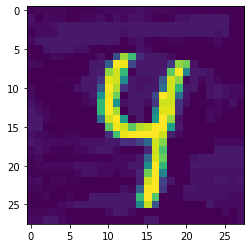

Epsilon = 0.260 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


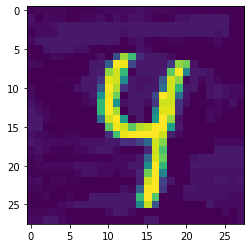

Epsilon = 0.280 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


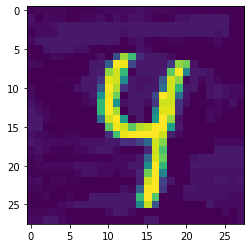

Epsilon = 0.300 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


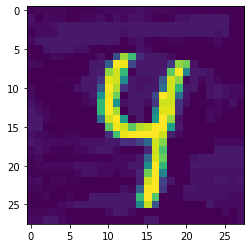

Epsilon = 0.320 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


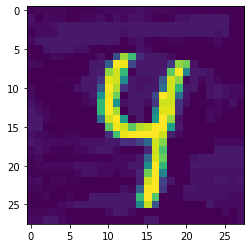

Epsilon = 0.340 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


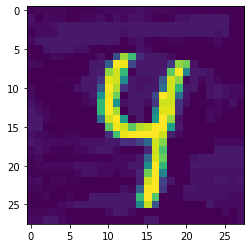

Epsilon = 0.360 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


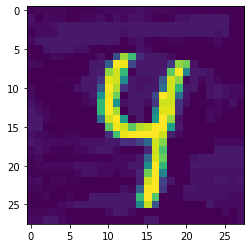

Epsilon = 0.380 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


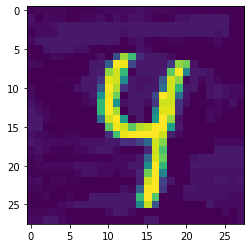

Epsilon = 0.400 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


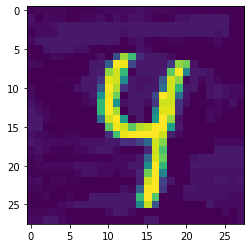

Epsilon = 0.420 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


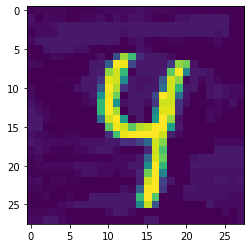

Epsilon = 0.440 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


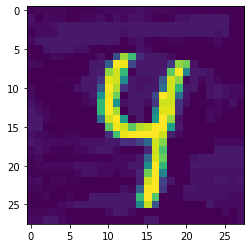

Epsilon = 0.460 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


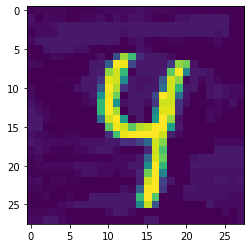

Epsilon = 0.480 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


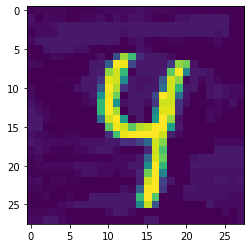

Epsilon = 0.500 
 Pred=9 : 53.12% Confidence 
 4 : 46.85% Confidence


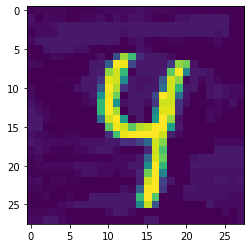

In [ ]:
for i, eps in enumerate(epsilons):
  adv = igsm(image, label, 4, eps//0.01, 0.01, eps)
  pred = mnist_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
  conf_igsm.append(pred[0][correct_inx])
  max = 0
  for j in range(pred.shape[1]):
    if(j != correct_inx and pred[0][j] >= max):
      max = pred[0][j]
  other_conf_igsm.append(max)
  display_images(adv, descriptions[i])

##### CW Attack

CW: Epsilion = 1.6759281158447266, c = 0.64 
 Pred=9 : 59.23% Confidence 
 4 : 40.74% Confidence


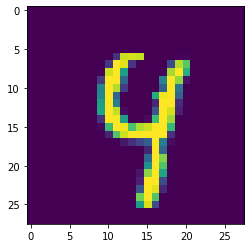

In [ ]:
adv, eps, c  = cw(image, 4, 50, 0.1)
pred = mnist_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
conf_cw.append(pred[0][correct_inx])
other_conf_cw.append(max)
display_images(adv, 'CW: Epsilion = {}, c = {}'.format(eps, c))

##### JSMA

6, 14, 0, tf.Tensor(0.5588235, shape=(), dtype=float32), 1.0 0 tf.Tensor(4, shape=(), dtype=int64)
6, 15, 0, tf.Tensor(0.5, shape=(), dtype=float32), 0.99999964 1 tf.Tensor(4, shape=(), dtype=int64)
6, 16, 0, tf.Tensor(0.5, shape=(), dtype=float32), 0.99992406 2 tf.Tensor(4, shape=(), dtype=int64)
6, 17, 0, tf.Tensor(0.5, shape=(), dtype=float32), 0.9907871 3 tf.Tensor(4, shape=(), dtype=int64)
6, 14, 0, tf.Tensor(1.0, shape=(), dtype=float32), 0.8617453 4 tf.Tensor(4, shape=(), dtype=int64)
6, 18, 0, tf.Tensor(0.5, shape=(), dtype=float32), 0.5832909 5 tf.Tensor(9, shape=(), dtype=int64)
JSMA: Epsilion = 5.0 
 Pred=9 : 58.33% Confidence 
 4 : 41.66% Confidence


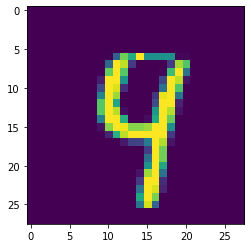

In [ ]:
adv, eps  = jsma(image, 4, 400, 0.5)
pred = mnist_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
display_images(adv, 'JSMA: Epsilion = {}'.format(eps))

#### Top part of image

In [12]:
amount_perturbation = 14
top_padding = 0
#top_padding = 20
bottom_padding = h-(amount_perturbation+top_padding)

masked_top = tf.concat([tf.zeros((1,top_padding,w,ch)), tf.ones((1,amount_perturbation,w,ch))], 1)
masked_top = tf.concat([masked_top, tf.zeros((1,bottom_padding,w,ch))], 1)

##### FGSM

Input 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


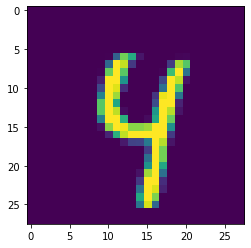

Epsilon = 0.020 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


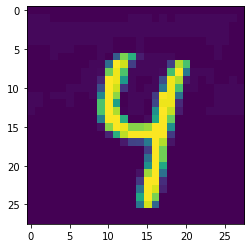

Epsilon = 0.040 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


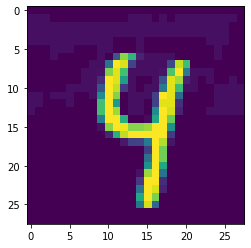

Epsilon = 0.060 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


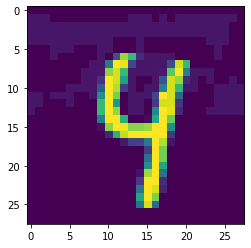

Epsilon = 0.080 
 Pred=4 : 99.95% Confidence 
 4 : 99.95% Confidence


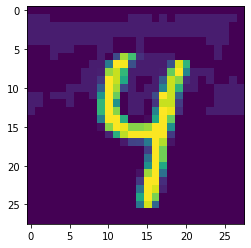

Epsilon = 0.100 
 Pred=4 : 98.85% Confidence 
 4 : 98.85% Confidence


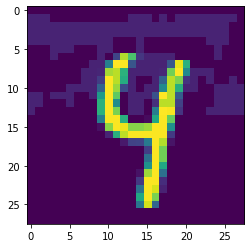

Epsilon = 0.120 
 Pred=4 : 81.83% Confidence 
 4 : 81.83% Confidence


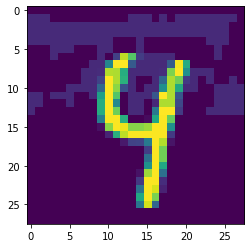

Epsilon = 0.140 
 Pred=9 : 71.89% Confidence 
 4 : 28.10% Confidence


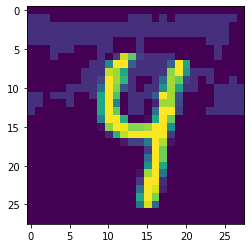

Epsilon = 0.160 
 Pred=9 : 95.43% Confidence 
 4 : 4.57% Confidence


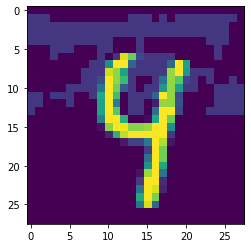

Epsilon = 0.180 
 Pred=9 : 99.26% Confidence 
 4 : 0.74% Confidence


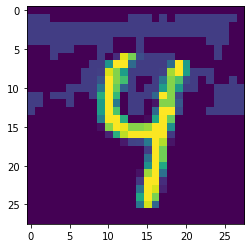

Epsilon = 0.200 
 Pred=9 : 99.82% Confidence 
 4 : 0.18% Confidence


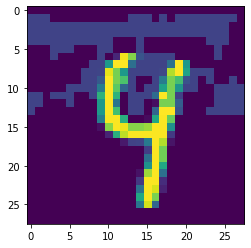

Epsilon = 0.220 
 Pred=9 : 99.95% Confidence 
 4 : 0.05% Confidence


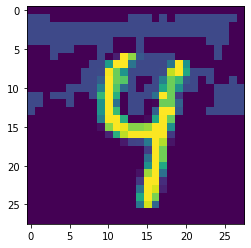

Epsilon = 0.240 
 Pred=9 : 99.98% Confidence 
 4 : 0.02% Confidence


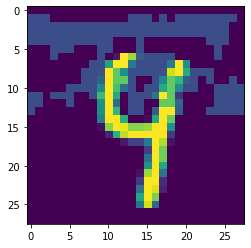

Epsilon = 0.260 
 Pred=9 : 99.99% Confidence 
 4 : 0.01% Confidence


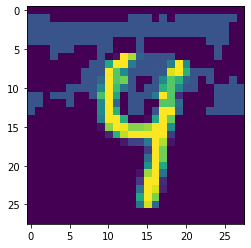

Epsilon = 0.280 
 Pred=9 : 100.00% Confidence 
 4 : 0.00% Confidence


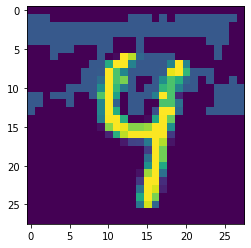

Epsilon = 0.300 
 Pred=9 : 100.00% Confidence 
 4 : 0.00% Confidence


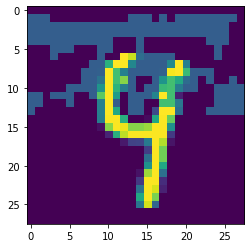

Epsilon = 0.320 
 Pred=9 : 100.00% Confidence 
 4 : 0.00% Confidence


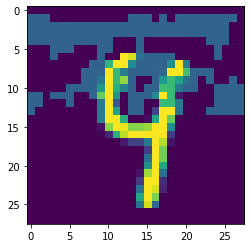

Epsilon = 0.340 
 Pred=9 : 100.00% Confidence 
 4 : 0.00% Confidence


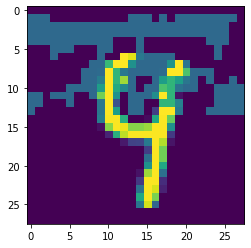

Epsilon = 0.360 
 Pred=9 : 100.00% Confidence 
 4 : 0.00% Confidence


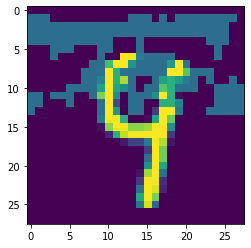

Epsilon = 0.380 
 Pred=9 : 100.00% Confidence 
 4 : 0.00% Confidence


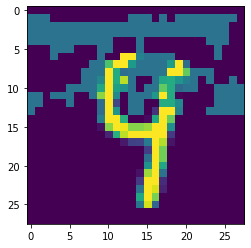

Epsilon = 0.400 
 Pred=9 : 100.00% Confidence 
 4 : 0.00% Confidence


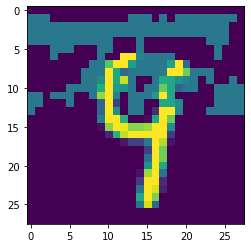

Epsilon = 0.420 
 Pred=9 : 100.00% Confidence 
 4 : 0.00% Confidence


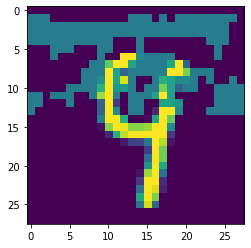

Epsilon = 0.440 
 Pred=9 : 100.00% Confidence 
 4 : 0.00% Confidence


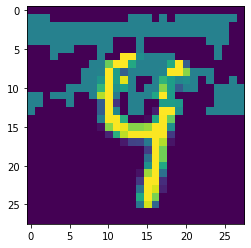

Epsilon = 0.460 
 Pred=9 : 100.00% Confidence 
 4 : 0.00% Confidence


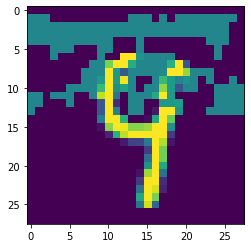

Epsilon = 0.480 
 Pred=9 : 100.00% Confidence 
 4 : 0.00% Confidence


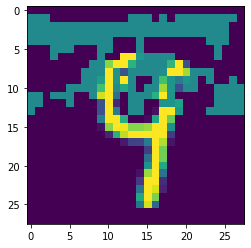

Epsilon = 0.500 
 Pred=9 : 100.00% Confidence 
 4 : 0.00% Confidence


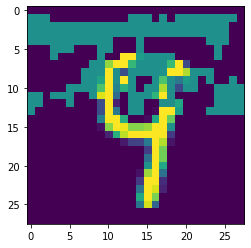

In [13]:
for i, eps in enumerate(epsilons):
  adv = fgsm(image, label, eps,masked_top)
  pred = mnist_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
  conf_fgsm_top.append(pred[0][correct_inx])
  max = 0
  for j in range(pred.shape[1]):
    if(j != correct_inx and pred[0][j] >= max):
      max = pred[0][j]
  other_conf_fgsm_top.append(max)
  display_images(adv, descriptions[i])

##### IGSM

Input 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


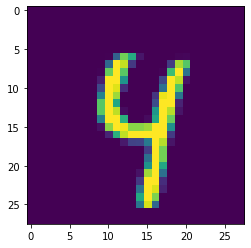

Epsilon = 0.020 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


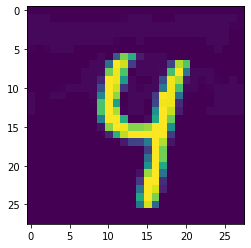

Epsilon = 0.040 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


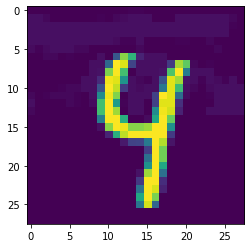

Epsilon = 0.060 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


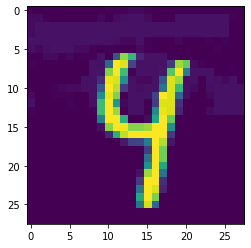

Epsilon = 0.080 
 Pred=4 : 98.47% Confidence 
 4 : 98.47% Confidence


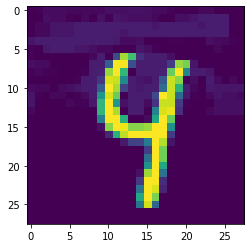

Epsilon = 0.100 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


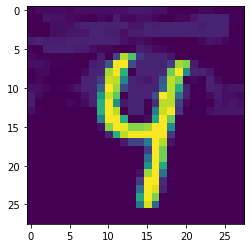

Epsilon = 0.120 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


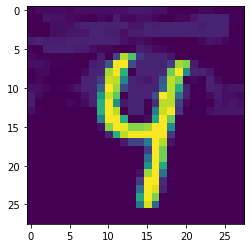

Epsilon = 0.140 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


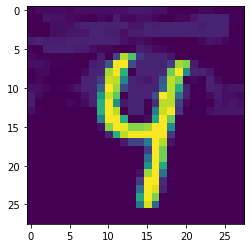

Epsilon = 0.160 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


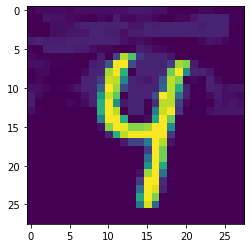

Epsilon = 0.180 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


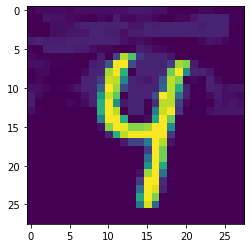

Epsilon = 0.200 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


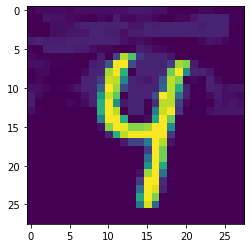

Epsilon = 0.220 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


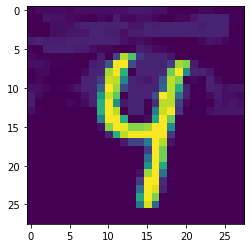

Epsilon = 0.240 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


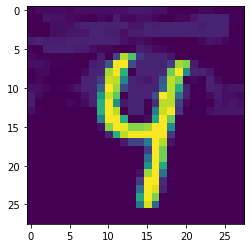

Epsilon = 0.260 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


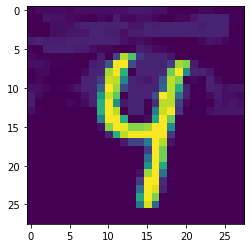

Epsilon = 0.280 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


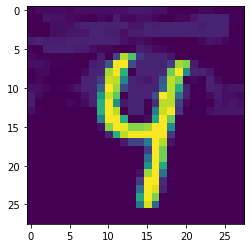

Epsilon = 0.300 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


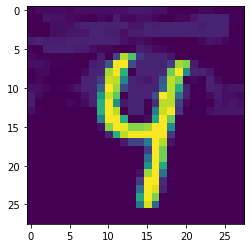

Epsilon = 0.320 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


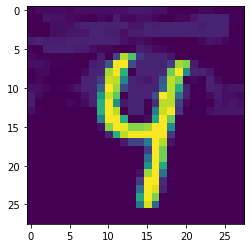

Epsilon = 0.340 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


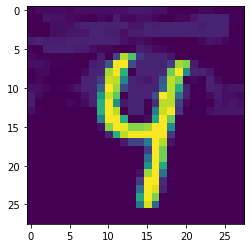

Epsilon = 0.360 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


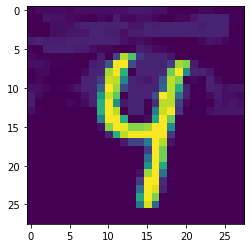

Epsilon = 0.380 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


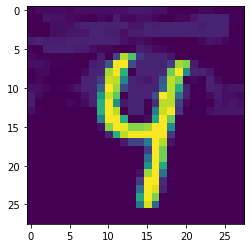

Epsilon = 0.400 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


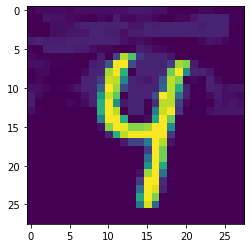

Epsilon = 0.420 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


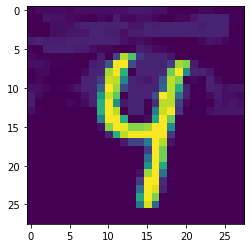

Epsilon = 0.440 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


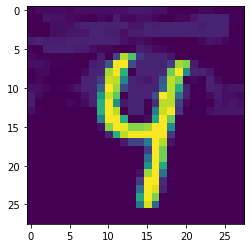

Epsilon = 0.460 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


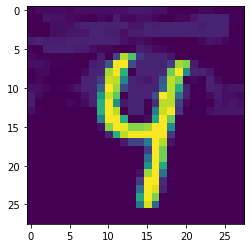

Epsilon = 0.480 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


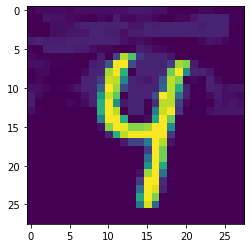

Epsilon = 0.500 
 Pred=9 : 61.51% Confidence 
 4 : 38.49% Confidence


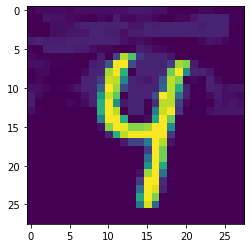

In [ ]:
for i, eps in enumerate(epsilons):
  adv = igsm(image, label, 4, eps//0.01, 0.01, eps, masked_top)
  pred = mnist_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
  conf_igsm_top.append(pred[0][correct_inx])
  max = 0
  for j in range(pred.shape[1]):
    if(j != correct_inx and pred[0][j] >= max):
      max = pred[0][j]
  other_conf_igsm_top.append(max)
  display_images(adv, descriptions[i])

##### CW Attack

CW: Epsilion = 1.9045644998550415, c = 1.28 
 Pred=9 : 53.45% Confidence 
 4 : 46.54% Confidence


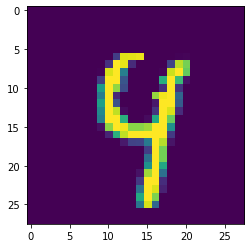

In [ ]:
adv, eps, c  = cw(image, 4, 50, 0.1, masked=masked_top)
pred = mnist_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
conf_cw.append(pred[0][correct_inx])
max = 0
for j in range(pred.shape[1]):
  if(j != correct_inx and pred[0][j] >= max):
    max = pred[0][j]
other_conf_cw.append(max)
display_images(adv, 'CW: Epsilion = {}, c = {}'.format(eps, c))

##### JSMA

6, 14, 0, tf.Tensor(0.5588235, shape=(), dtype=float32), 1.0 0 tf.Tensor(4, shape=(), dtype=int64)
6, 15, 0, tf.Tensor(0.5, shape=(), dtype=float32), 0.99999964 1 tf.Tensor(4, shape=(), dtype=int64)
6, 16, 0, tf.Tensor(0.5, shape=(), dtype=float32), 0.99992406 2 tf.Tensor(4, shape=(), dtype=int64)
6, 17, 0, tf.Tensor(0.5, shape=(), dtype=float32), 0.9907871 3 tf.Tensor(4, shape=(), dtype=int64)
6, 14, 0, tf.Tensor(1.0, shape=(), dtype=float32), 0.8617453 4 tf.Tensor(4, shape=(), dtype=int64)
6, 18, 0, tf.Tensor(0.5, shape=(), dtype=float32), 0.5832909 5 tf.Tensor(9, shape=(), dtype=int64)
JSMA: Epsilion = 5.0 
 Pred=9 : 58.33% Confidence 
 4 : 41.66% Confidence


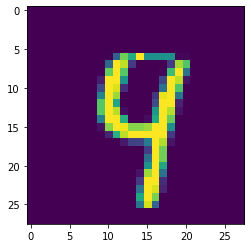

In [ ]:
adv, eps  = jsma(image, 4, 400, 0.5, masked=masked_top)
pred = mnist_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
display_images(adv, 'JSMA: Epsilion = {}'.format(eps))

#### Bottom

In [ ]:
amount_perturbation = 14
top_padding = 14
bottom_padding = h-(amount_perturbation+top_padding)

masked_bottom = tf.concat([tf.zeros((1,top_padding,w,ch)), tf.ones((1,amount_perturbation,w,ch))], 1)
masked_bottom = tf.concat([masked_bottom, tf.zeros((1,bottom_padding,w,ch))], 1)

###### FGSM

Input 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


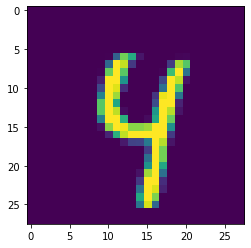

Epsilon = 0.020 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


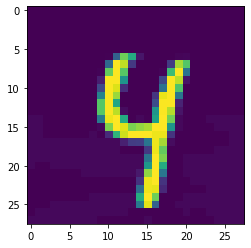

Epsilon = 0.040 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


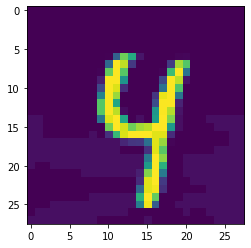

Epsilon = 0.060 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


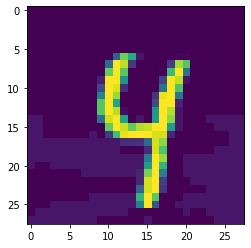

Epsilon = 0.080 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


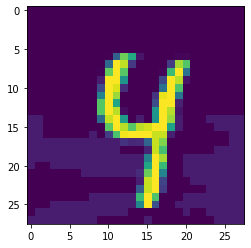

Epsilon = 0.100 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


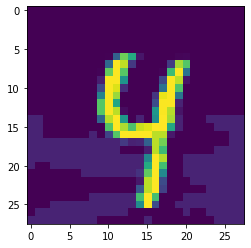

Epsilon = 0.120 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


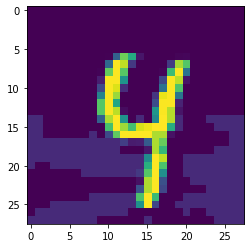

Epsilon = 0.140 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


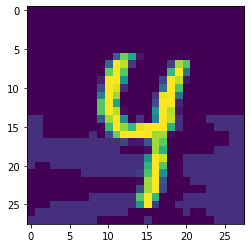

Epsilon = 0.160 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


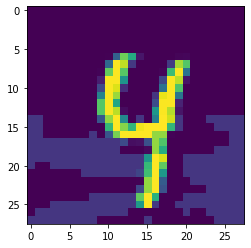

Epsilon = 0.180 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


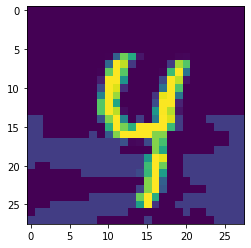

Epsilon = 0.200 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


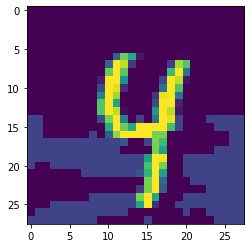

Epsilon = 0.220 
 Pred=4 : 99.99% Confidence 
 4 : 99.99% Confidence


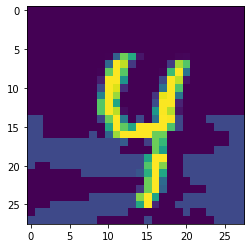

Epsilon = 0.240 
 Pred=4 : 99.99% Confidence 
 4 : 99.99% Confidence


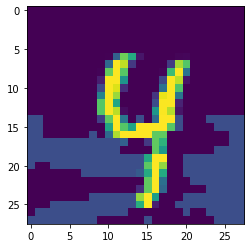

Epsilon = 0.260 
 Pred=4 : 99.97% Confidence 
 4 : 99.97% Confidence


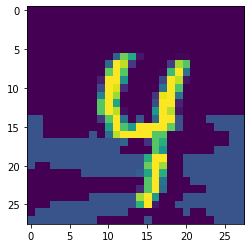

Epsilon = 0.280 
 Pred=4 : 99.93% Confidence 
 4 : 99.93% Confidence


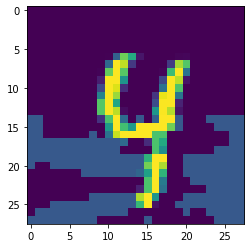

Epsilon = 0.300 
 Pred=4 : 99.84% Confidence 
 4 : 99.84% Confidence


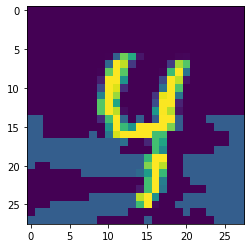

Epsilon = 0.320 
 Pred=4 : 99.60% Confidence 
 4 : 99.60% Confidence


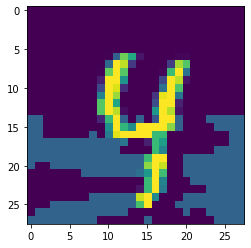

Epsilon = 0.340 
 Pred=4 : 98.95% Confidence 
 4 : 98.95% Confidence


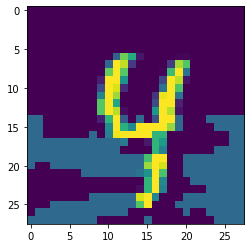

Epsilon = 0.360 
 Pred=4 : 97.39% Confidence 
 4 : 97.39% Confidence


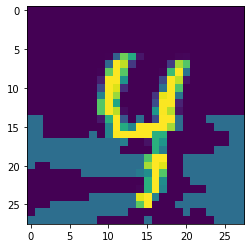

Epsilon = 0.380 
 Pred=4 : 93.60% Confidence 
 4 : 93.60% Confidence


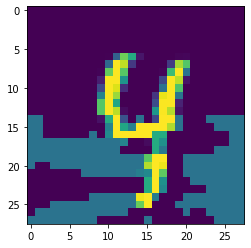

Epsilon = 0.400 
 Pred=4 : 86.16% Confidence 
 4 : 86.16% Confidence


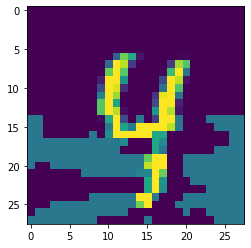

Epsilon = 0.420 
 Pred=4 : 72.28% Confidence 
 4 : 72.28% Confidence


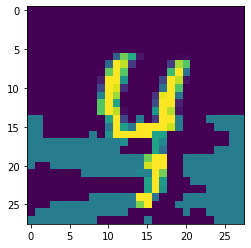

Epsilon = 0.440 
 Pred=4 : 54.52% Confidence 
 4 : 54.52% Confidence


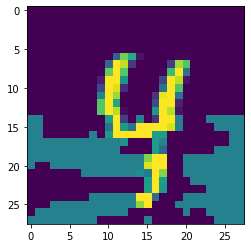

Epsilon = 0.460 
 Pred=8 : 61.75% Confidence 
 4 : 37.16% Confidence


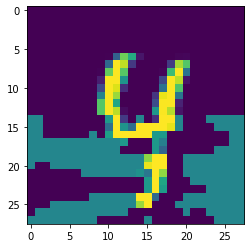

Epsilon = 0.480 
 Pred=8 : 72.52% Confidence 
 4 : 26.57% Confidence


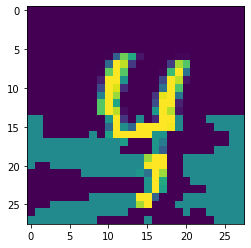

Epsilon = 0.500 
 Pred=8 : 79.15% Confidence 
 4 : 20.12% Confidence


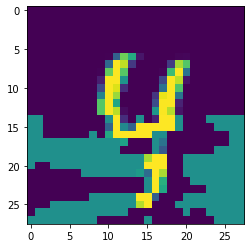

In [ ]:
for i, eps in enumerate(epsilons):
  adv = fgsm(image, label, eps,masked_bottom)  
  pred = mnist_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
  conf_fgsm_bottom.append(pred[0][correct_inx])
  max = 0
  for j in range(pred.shape[1]):
    if(j != correct_inx and pred[0][j] >= max):
      max = pred[0][j]
  other_conf_fgsm_bottom.append(max)
  display_images(adv, descriptions[i])

##### IGSM

Input 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


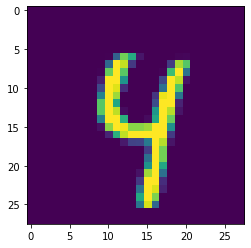

Epsilon = 0.020 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


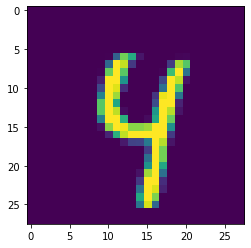

Epsilon = 0.040 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


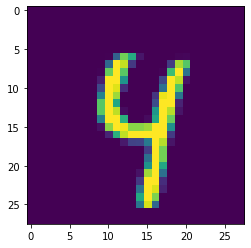

Epsilon = 0.060 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


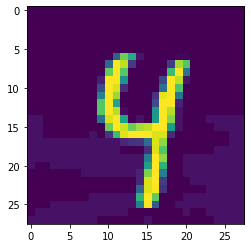

Epsilon = 0.080 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


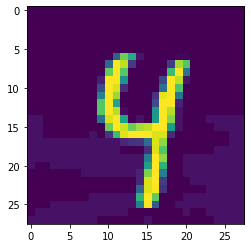

Epsilon = 0.100 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


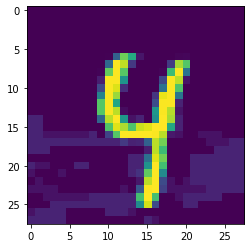

Epsilon = 0.120 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


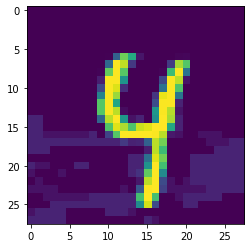

Epsilon = 0.140 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


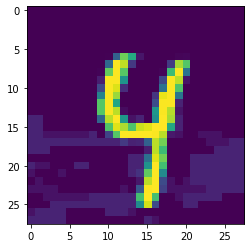

Epsilon = 0.160 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


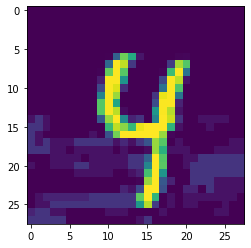

Epsilon = 0.180 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


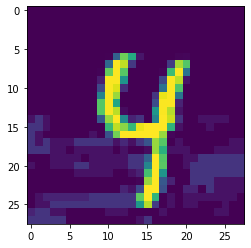

Epsilon = 0.200 
 Pred=4 : 100.00% Confidence 
 4 : 100.00% Confidence


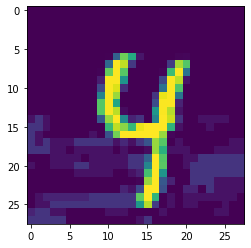

Epsilon = 0.220 
 Pred=4 : 99.94% Confidence 
 4 : 99.94% Confidence


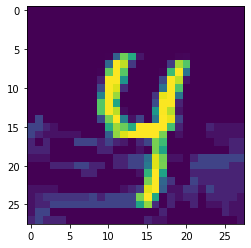

Epsilon = 0.240 
 Pred=4 : 99.94% Confidence 
 4 : 99.94% Confidence


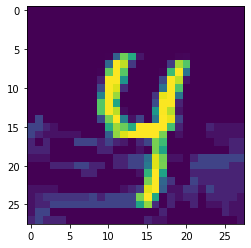

Epsilon = 0.260 
 Pred=4 : 93.20% Confidence 
 4 : 93.20% Confidence


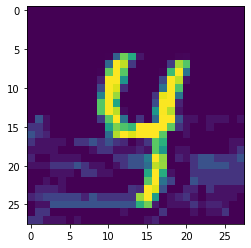

Epsilon = 0.280 
 Pred=4 : 93.20% Confidence 
 4 : 93.20% Confidence


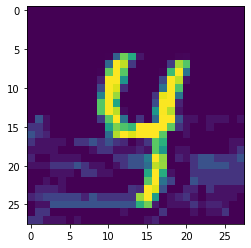

Epsilon = 0.300 
 Pred=4 : 93.20% Confidence 
 4 : 93.20% Confidence


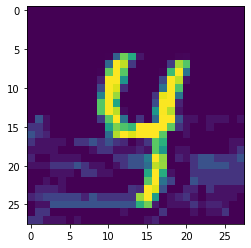

Epsilon = 0.320 
 Pred=3 : 59.07% Confidence 
 4 : 9.66% Confidence


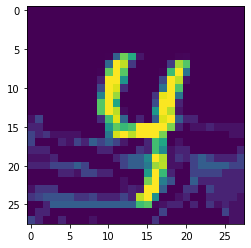

Epsilon = 0.340 
 Pred=3 : 59.07% Confidence 
 4 : 9.66% Confidence


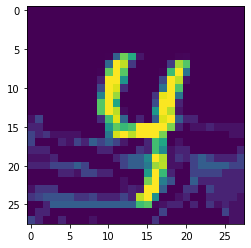

Epsilon = 0.360 
 Pred=3 : 59.07% Confidence 
 4 : 9.66% Confidence


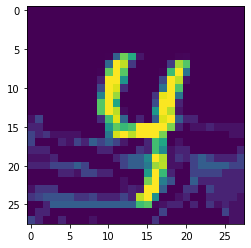

Epsilon = 0.380 
 Pred=3 : 59.07% Confidence 
 4 : 9.66% Confidence


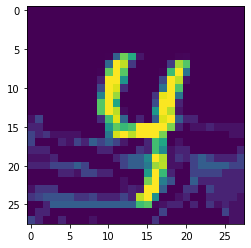

Epsilon = 0.400 
 Pred=3 : 59.07% Confidence 
 4 : 9.66% Confidence


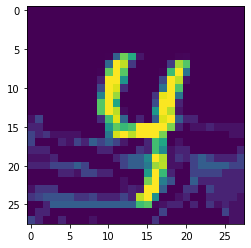

Epsilon = 0.420 
 Pred=3 : 59.07% Confidence 
 4 : 9.66% Confidence


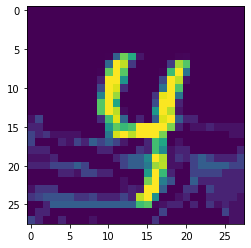

Epsilon = 0.440 
 Pred=3 : 59.07% Confidence 
 4 : 9.66% Confidence


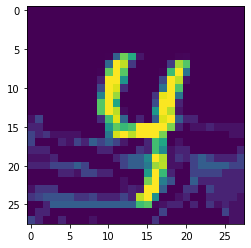

Epsilon = 0.460 
 Pred=3 : 59.07% Confidence 
 4 : 9.66% Confidence


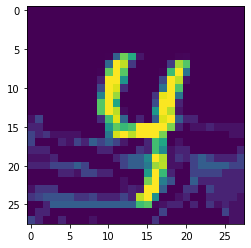

Epsilon = 0.480 
 Pred=3 : 59.07% Confidence 
 4 : 9.66% Confidence


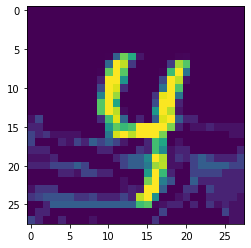

Epsilon = 0.500 
 Pred=3 : 59.07% Confidence 
 4 : 9.66% Confidence


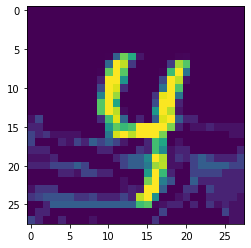

In [ ]:
for i, eps in enumerate(epsilons):
  adv = igsm(image, label, 4, eps//0.05, 0.05, eps, masked_bottom)
  pred = mnist_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
  conf_igsm_bottom.append(pred[0][correct_inx])
  max = 0
  for j in range(pred.shape[1]):
    if(j != correct_inx and pred[0][j] >= max):
      max = pred[0][j]
  other_conf_igsm_bottom.append(max)
  display_images(adv, descriptions[i])

##### CW Attack

CW: Epsilion = 2.943890333175659, c = 5.12 
 Pred=5 : 44.45% Confidence 
 4 : 43.51% Confidence


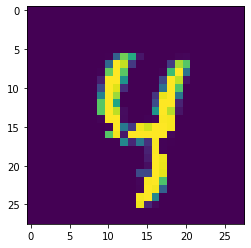

In [ ]:
adv, eps, c  = cw(image, 4, 50, 0.1, masked=masked_bottom)
pred = mnist_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
conf_cw.append(pred[0][correct_inx])
max = 0
for j in range(pred.shape[1]):
  if(j != correct_inx and pred[0][j] >= max):
    max = pred[0][j]
other_conf_cw.append(max)
display_images(adv, 'CW: Epsilion = {}, c = {}'.format(eps, c))

##### JSMA

17, 10, 0, tf.Tensor(0.5, shape=(), dtype=float32), 1.0 0 tf.Tensor(4, shape=(), dtype=int64)
17, 8, 0, tf.Tensor(0.5, shape=(), dtype=float32), 1.0 1 tf.Tensor(4, shape=(), dtype=int64)
18, 7, 0, tf.Tensor(0.5, shape=(), dtype=float32), 1.0 2 tf.Tensor(4, shape=(), dtype=int64)
22, 17, 0, tf.Tensor(0.62941176, shape=(), dtype=float32), 1.0 3 tf.Tensor(4, shape=(), dtype=int64)
21, 23, 0, tf.Tensor(0.5, shape=(), dtype=float32), 1.0 4 tf.Tensor(4, shape=(), dtype=int64)
20, 22, 0, tf.Tensor(0.5, shape=(), dtype=float32), 1.0 5 tf.Tensor(4, shape=(), dtype=int64)
20, 17, 0, tf.Tensor(1.0, shape=(), dtype=float32), 1.0 6 tf.Tensor(4, shape=(), dtype=int64)
17, 6, 0, tf.Tensor(0.5, shape=(), dtype=float32), 1.0 7 tf.Tensor(4, shape=(), dtype=int64)
25, 13, 0, tf.Tensor(0.5, shape=(), dtype=float32), 1.0 8 tf.Tensor(4, shape=(), dtype=int64)
25, 12, 0, tf.Tensor(0.5, shape=(), dtype=float32), 1.0 9 tf.Tensor(4, shape=(), dtype=int64)
25, 11, 0, tf.Tensor(0.5, shape=(), dtype=float32), 1.0 

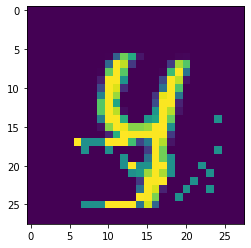

In [ ]:
adv, eps  = jsma(image, 4, 400, 0.5, masked=masked_bottom)
pred = mnist_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
display_images(adv, 'JSMA: Epsilion = {}'.format(eps))

#### Save variables

In [ ]:
with open(path + 'objs_l_inf.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([conf_fgsm, conf_igsm, conf_fgsm_top,conf_igsm_top, 
                 conf_fgsm_bottom, conf_igsm_bottom,
                 other_conf_fgsm, other_conf_igsm, other_conf_fgsm_top,
                 other_conf_igsm_top, other_conf_fgsm_bottom,
                 other_conf_igsm_bottom ], f)



#### Load variables

In [ ]:
# Getting back the objects:
with open(path + 'objs_l_inf.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    conf_fgsm, conf_igsm, conf_fgsm_top,conf_igsm_top, conf_fgsm_bottom, conf_igsm_bottom, other_conf_fgsm, other_conf_igsm, other_conf_fgsm_top, other_conf_igsm_top, other_conf_fgsm_bottom, other_conf_igsm_bottom = pickle.load(f)

#### Result of L Infinite

L Infinite Full

Text(0, 0.5, 'Confidence')

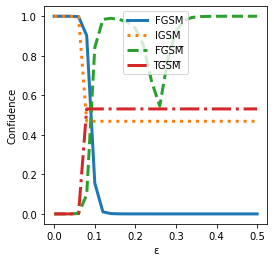

In [ ]:
plt.plot(epsilons, conf_fgsm, epsilons, conf_igsm, ':', epsilons, other_conf_fgsm, '--', epsilons, other_conf_igsm, '-.', linewidth=3)
plt.legend(['FGSM','IGSM',u'F\u0305G\u0305S\u0305M\u0305',u'I\u0305G\u0305S\u0305M\u0305'])
plt.xlabel(u'\u03B5')
plt.ylabel('Confidence')

L Infinite Top

Text(0, 0.5, 'Confidence')

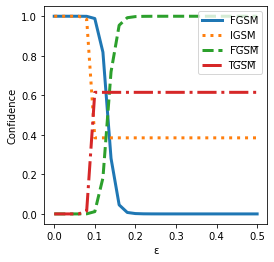

In [ ]:
plt.plot(epsilons, conf_fgsm_top, epsilons, conf_igsm_top, ':', epsilons, other_conf_fgsm_top, '--', epsilons, other_conf_igsm_top, '-.', linewidth=3)
plt.legend(['FGSM','IGSM',u'F\u0305G\u0305S\u0305M\u0305',u'I\u0305G\u0305S\u0305M\u0305'])
plt.xlabel(u'\u03B5')
plt.ylabel('Confidence')

L Infinite Bottom

Text(0, 0.5, 'Confidence')

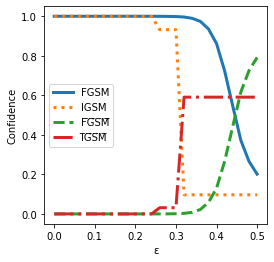

In [ ]:
plt.plot(epsilons, conf_fgsm_bottom, epsilons, conf_igsm_bottom, ':', epsilons, other_conf_fgsm_bottom, '--', epsilons, other_conf_igsm_bottom, '-.', linewidth=3)
plt.legend(['FGSM','IGSM',u'F\u0305G\u0305S\u0305M\u0305',u'I\u0305G\u0305S\u0305M\u0305'])
plt.xlabel(u'\u03B5')
plt.ylabel('Confidence')

#### Success rate of L Inifinite

In [ ]:
sum_fgsm_full = np.array([0,0,0,0,0,0,0,0,0,0])
sum_fgsm_top = np.array([0,0,0,0,0,0,0,0,0,0])
sum_fgsm_bottom = np.array([0,0,0,0,0,0,0,0,0,0])
eps_fgsm_full = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_fgsm_top = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_fgsm_bottom = np.array([0.0,0,0,0,0,0,0,0,0,0])

sum_igsm_full = np.array([0,0,0,0,0,0,0,0,0,0])
sum_igsm_top = np.array([0,0,0,0,0,0,0,0,0,0])
sum_igsm_bottom = np.array([0,0,0,0,0,0,0,0,0,0])
eps_igsm_full = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_igsm_top = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_igsm_bottom = np.array([0.0,0,0,0,0,0,0,0,0,0])

n_test = len(x_test)

In [ ]:
epsilons_no_zero = epsilons[1:]
for i in range(200):
  print('{}/{}'.format(i+1,200))
  image = x_test[i]
  correct_class = y_test[i]
  pred, _ = get_class_confidence(image)
  if(correct_class != pred):
    continue
  sum_correct_class[correct_class] += 1
  label = tf.reshape(y_test_oh[i], (1,10))
#FGSM FULL
  for j, eps in enumerate(epsilons_no_zero):
    adv = fgsm(image,label,eps)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      sum_fgsm_full[correct_class] += 1
      eps_fgsm_full[correct_class] += eps
      break
#IGSM FULL
  for j, eps in enumerate(epsilons_no_zero):
    adv = igsm(image,label,eps // 0.02,0.02, eps)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      sum_igsm_full[correct_class] += 1
      eps_igsm_full[correct_class] += eps
      break
#FGSM TOP
  for j, eps in enumerate(epsilons_no_zero):
    adv = fgsm(image,label,eps,masked_top)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      sum_fgsm_top[correct_class] += 1
      eps_fgsm_top[correct_class] += eps
      break
#IGSM TOP
  for j, eps in enumerate(epsilons_no_zero):
    adv = igsm(image,label,eps // 0.02,0.02, eps, masked_top)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      sum_igsm_top[correct_class] += 1
      eps_igsm_top[correct_class] += eps
      break
#FGSM BOTTOM
  for j, eps in enumerate(epsilons_no_zero):
    adv = fgsm(image,label,eps,masked_bottom)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      sum_fgsm_bottom[correct_class] += 1
      eps_fgsm_bottom[correct_class] += eps
      break
#IGSM BOTTOM
  for j, eps in enumerate(epsilons_no_zero):
    adv = igsm(image,label,eps // 0.02,0.02, eps, masked_bottom)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      sum_igsm_bottom[correct_class] += 1
      eps_igsm_bottom[correct_class] += eps
      break

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/

In [ ]:
sr_fgsm_full = sum_fgsm_full / sum_correct_class
sr_fgsm_top = sum_fgsm_top / sum_correct_class
sr_fgsm_bottom = sum_fgsm_bottom / sum_correct_class

sr_igsm_full = sum_igsm_full / sum_correct_class
sr_igsm_top = sum_igsm_top / sum_correct_class
sr_igsm_bottom = sum_igsm_bottom / sum_correct_class

avg_eps_fgsm_full = eps_fgsm_full / sum_correct_class
avg_eps_igsm_full = eps_igsm_full / sum_correct_class

avg_eps_fgsm_top = eps_fgsm_top / sum_correct_class
avg_eps_igsm_top = eps_igsm_top / sum_correct_class

avg_eps_fgsm_bottom = eps_fgsm_bottom / sum_correct_class
avg_eps_igsm_bottom = eps_igsm_bottom / sum_correct_class

for i in range(10):
  print('Class {}'.format(i))
  print('All the data that is classified as its correct class: {}'.format(sum_correct_class[i]))
  print('Success rate of FGSM with full input: {:.2f}%'.format(sr_fgsm_full[i]*100))
  print('Success rate of FGSM with top input: {:.2f}%'.format(sr_fgsm_top[i]*100))
  print('Success rate of FGSM with bottom input: {:.2f}%'.format(sr_fgsm_bottom[i]*100))

  print('Success rate of IGSM with full input: {:.2f}%'.format(sr_igsm_full[i]*100))
  print('Success rate of IGSM with top input: {:.2f}%'.format(sr_igsm_top[i]*100))
  print('Success rate of IGSM with bottom input: {:.2f}%'.format(sr_igsm_bottom[i]*100))

  print('Average eps of FGSM with full input: {:.4f}'.format(avg_eps_fgsm_full[i]))
  print('Average eps of FGSM with top input: {:.4f}'.format(avg_eps_fgsm_top[i]))
  print('Average eps of FGSM with bottom input: {:.4f}'.format(avg_eps_fgsm_bottom[i]))

  print('Average eps of IGSM with full input: {:.4f}'.format(avg_eps_igsm_full[i]))
  print('Average eps of IGSM with top input: {:.4f}'.format(avg_eps_igsm_top[i]))
  print('Average eps of IGSM with bottom input: {:.4f}'.format(avg_eps_igsm_bottom[i]))



Class 0
All the data that is classified as its correct class: 17
Success rate of FGSM with full input: 94.12%
Success rate of FGSM with top input: 5.88%
Success rate of FGSM with bottom input: 76.47%
Success rate of IGSM with full input: 100.00%
Success rate of IGSM with top input: 94.12%
Success rate of IGSM with bottom input: 100.00%
Average eps of FGSM with full input: 0.2082
Average eps of FGSM with top input: 0.0176
Average eps of FGSM with bottom input: 0.2447
Average eps of IGSM with full input: 0.1612
Average eps of IGSM with top input: 0.3118
Average eps of IGSM with bottom input: 0.2376
Class 1
All the data that is classified as its correct class: 28
Success rate of FGSM with full input: 100.00%
Success rate of FGSM with top input: 100.00%
Success rate of FGSM with bottom input: 96.43%
Success rate of IGSM with full input: 100.00%
Success rate of IGSM with top input: 100.00%
Success rate of IGSM with bottom input: 100.00%
Average eps of FGSM with full input: 0.1021
Average ep

In [ ]:
sum_sr_fgsm_full = sum(sum_fgsm_full) / sum(sum_correct_class)
sum_sr_fgsm_top = sum(sum_fgsm_top) / sum(sum_correct_class)
sum_sr_fgsm_bottom = sum(sum_fgsm_bottom) / sum(sum_correct_class)

sum_sr_igsm_full = sum(sum_igsm_full) / sum(sum_correct_class)
sum_sr_igsm_top = sum(sum_igsm_top) / sum(sum_correct_class)
sum_sr_igsm_bottom = sum(sum_igsm_bottom) / sum(sum_correct_class)

sum_avg_eps_fgsm_full = sum(eps_fgsm_full) / sum(sum_correct_class)
sum_avg_eps_igsm_full = sum(eps_igsm_full) / sum(sum_correct_class)

sum_avg_eps_fgsm_top = sum(eps_fgsm_top) / sum(sum_correct_class)
sum_avg_eps_igsm_top = sum(eps_igsm_top) / sum(sum_correct_class)

sum_avg_eps_fgsm_bottom = sum(eps_fgsm_bottom) / sum(sum_correct_class)
sum_avg_eps_igsm_bottom = sum(eps_igsm_bottom) / sum(sum_correct_class)

print('All the data that is classified as its correct class: {}'.format(sum(sum_correct_class)))
print('Success rate of FGSM with full input: {:.2f}%'.format(sum_sr_fgsm_full*100))
print('Success rate of FGSM with top input: {:.2f}%'.format(sum_sr_fgsm_top*100))
print('Success rate of FGSM with bottom input: {:.2f}%'.format(sum_sr_fgsm_bottom*100))

print('Success rate of IGSM with full input: {:.2f}%'.format(sum_sr_igsm_full*100))
print('Success rate of IGSM with top input: {:.2f}%'.format(sum_sr_igsm_top*100))
print('Success rate of IGSM with bottom input: {:.2f}%'.format(sum_sr_igsm_bottom*100))

print('Average eps of FGSM with full input: {:.4f}'.format(sum_avg_eps_fgsm_full))
print('Average eps of FGSM with top input: {:.4f}'.format(sum_avg_eps_fgsm_top))
print('Average eps of FGSM with bottom input: {:.4f}'.format(sum_avg_eps_fgsm_bottom))

print('Average eps of IGSM with full input: {:.4f}'.format(sum_avg_eps_igsm_full))
print('Average eps of IGSM with top input: {:.4f}'.format(sum_avg_eps_igsm_top))
print('Average eps of IGSM with bottom input: {:.4f}'.format(sum_avg_eps_igsm_bottom))

All the data that is classified as its correct class: 200
Success rate of FGSM with full input: 97.00%
Success rate of FGSM with top input: 56.50%
Success rate of FGSM with bottom input: 57.00%
Success rate of IGSM with full input: 100.00%
Success rate of IGSM with top input: 95.50%
Success rate of IGSM with bottom input: 97.00%
Average eps of FGSM with full input: 0.1465
Average eps of FGSM with top input: 0.1286
Average eps of FGSM with bottom input: 0.1347
Average eps of IGSM with full input: 0.1101
Average eps of IGSM with top input: 0.1994
Average eps of IGSM with bottom input: 0.1985


#### CW's success rate

In [ ]:
sum_cw_full = np.array([0,0,0,0,0,0,0,0,0,0])
sum_cw_top = np.array([0,0,0,0,0,0,0,0,0,0])
sum_cw_bottom = np.array([0,0,0,0,0,0,0,0,0,0])
eps_cw_full = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_cw_top = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_cw_bottom = np.array([0.0,0,0,0,0,0,0,0,0,0])
c_cw_full = np.array([0.0,0,0,0,0,0,0,0,0,0])
c_cw_top = np.array([0.0,0,0,0,0,0,0,0,0,0])
c_cw_bottom = np.array([0.0,0,0,0,0,0,0,0,0,0])

sum_correct_class = np.array([0,0,0,0,0,0,0,0,0,0])

In [ ]:
for i in range(200):
  print('{}/{}'.format(i+1,200))
  image = x_test[i]
  correct_class = y_test[i]
  pred, _ = get_class_confidence(image)
  if(correct_class != pred):
    continue
  sum_correct_class[correct_class] += 1
  label = tf.reshape(y_test_oh[i], (1,10))
#CW FULL
  adv, eps, c = cw(image, correct_class, 50, 0.1)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= 10):
    sum_cw_full[correct_class] += 1
    eps_cw_full[correct_class] += eps
    c_cw_full[correct_class] += c
#CW TOP
  adv, eps, c = cw(image, correct_class, 50, 0.1, masked=masked_top)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= 10):
    sum_cw_top[correct_class] += 1
    eps_cw_top[correct_class] += eps
    c_cw_top[correct_class] += c
#CW BOTTOM
  adv, eps, c = cw(image, correct_class, 50, 0.1, masked=masked_bottom)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= 10):
    sum_cw_bottom[correct_class] += 1
    eps_cw_bottom[correct_class] += eps
    c_cw_bottom[correct_class] += c

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/

In [ ]:
sr_cw_full = sum_cw_full / sum_correct_class
sr_cw_top = sum_cw_top / sum_correct_class
sr_cw_bottom = sum_cw_bottom / sum_correct_class

avg_eps_cw_full = eps_cw_full / sum_correct_class

avg_eps_cw_top = eps_cw_top / sum_correct_class

avg_eps_cw_bottom = eps_cw_bottom / sum_correct_class

avg_c_cw_full = c_cw_full / sum_correct_class

avg_c_cw_top = c_cw_top / sum_correct_class

avg_c_cw_bottom = c_cw_bottom / sum_correct_class

for i in range(10):
  print('Class {}'.format(i))
  print('All the data that is classified as its correct class: {}'.format(sum_correct_class[i]))
  print('Success rate of CW with full input: {:.2f}%'.format(sr_cw_full[i]*100))
  print('Success rate of CW with top input: {:.2f}%'.format(sr_cw_top[i]*100))
  print('Success rate of CW with bottom input: {:.2f}%'.format(sr_cw_bottom[i]*100))

  print('Average eps of CW with full input: {:.4f}'.format(avg_eps_cw_full[i]))
  print('Average eps of CW with top input: {:.4f}'.format(avg_eps_cw_top[i]))
  print('Average eps of CW with bottom input: {:.4f}'.format(avg_eps_cw_bottom[i]))

  print('Average c of CW with full input: {:.4f}'.format(avg_c_cw_full[i]))
  print('Average c of CW with top input: {:.4f}'.format(avg_c_cw_top[i]))
  print('Average c of CW with bottom input: {:.4f}'.format(avg_c_cw_bottom[i]))



Class 0
All the data that is classified as its correct class: 17
Success rate of CW with full input: 94.12%
Success rate of CW with top input: 82.35%
Success rate of CW with bottom input: 94.12%
Average eps of CW with full input: 2.6900
Average eps of CW with top input: 3.0545
Average eps of CW with bottom input: 2.7664
Average c of CW with full input: 3.0871
Average c of CW with top input: 17.7694
Average c of CW with bottom input: 5.7224
Class 1
All the data that is classified as its correct class: 28
Success rate of CW with full input: 96.43%
Success rate of CW with top input: 89.29%
Success rate of CW with bottom input: 78.57%
Average eps of CW with full input: 2.0977
Average eps of CW with top input: 2.1183
Average eps of CW with bottom input: 1.9552
Average c of CW with full input: 2.7543
Average c of CW with top input: 5.8743
Average c of CW with bottom input: 16.6857
Class 2
All the data that is classified as its correct class: 16
Success rate of CW with full input: 100.00%
Suc

In [ ]:
sum_sr_cw_full = sum(sum_cw_full) / sum(sum_correct_class)
sum_sr_cw_top = sum(sum_cw_top) / sum(sum_correct_class)
sum_sr_cw_bottom = sum(sum_cw_bottom) / sum(sum_correct_class)

sum_avg_eps_cw_full = sum(eps_cw_full) / sum(sum_correct_class)
sum_avg_eps_cw_top = sum(eps_cw_top) / sum(sum_correct_class)
sum_avg_eps_cw_bottom = sum(eps_cw_bottom) / sum(sum_correct_class)

sum_avg_c_cw_full = sum(c_cw_full) / sum(sum_correct_class)
sum_avg_c_cw_top = sum(c_cw_top) / sum(sum_correct_class)
sum_avg_c_cw_bottom = sum(c_cw_bottom) / sum(sum_correct_class)

print('All the data that is classified as its correct class: {}'.format(sum(sum_correct_class)))
print('Success rate of CW with full input: {:.2f}%'.format(sum_sr_cw_full*100))
print('Success rate of CW with top input: {:.2f}%'.format(sum_sr_cw_top*100))
print('Success rate of CW with bottom input: {:.2f}%'.format(sum_sr_cw_bottom*100))

print('Average eps of CW with full input: {:.4f}'.format(sum_avg_eps_cw_full))
print('Average eps of CW with top input: {:.4f}'.format(sum_avg_eps_cw_top))
print('Average eps of CW with bottom input: {:.4f}'.format(sum_avg_eps_cw_bottom))

print('Average c of CW with full input: {:.4f}'.format(sum_avg_c_cw_full))
print('Average c of CW with top input: {:.4f}'.format(sum_avg_c_cw_top))
print('Average c of CW with bottom input: {:.4f}'.format(sum_avg_c_cw_bottom))

All the data that is classified as its correct class: 200
Success rate of CW with full input: 97.00%
Success rate of CW with top input: 83.00%
Success rate of CW with bottom input: 87.00%
Average eps of CW with full input: 2.4350
Average eps of CW with top input: 2.3977
Average eps of CW with bottom input: 2.5226
Average c of CW with full input: 3.1856
Average c of CW with top input: 11.0688
Average c of CW with bottom input: 13.4032


#### JSMA's success rate

In [ ]:
sum_jsma_full = np.array([0,0,0,0,0,0,0,0,0,0])
sum_jsma_top = np.array([0,0,0,0,0,0,0,0,0,0])
sum_jsma_bottom = np.array([0,0,0,0,0,0,0,0,0,0])
eps_jsma_full = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_jsma_top = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_jsma_bottom = np.array([0.0,0,0,0,0,0,0,0,0,0])

sum_correct_class = np.array([0,0,0,0,0,0,0,0,0,0])

In [ ]:
for i in range(200):
  print('{}/{}'.format(i+1,200))
  image = x_test[i]
  correct_class = y_test[i]
  pred, _ = get_class_confidence(image)
  if(correct_class != pred):
    continue
  sum_correct_class[correct_class] += 1
  label = tf.reshape(y_test_oh[i], (1,10))
#JSMA FULL
  adv, eps = jsma(image,correct_class,80,0.5)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= h*w*ch*0.05):
    sum_jsma_full[correct_class] += 1
    eps_jsma_full[correct_class] += eps
#JSMA TOP
  adv, eps = jsma(image,correct_class,80,0.5, masked=masked_top)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= h*w*ch*0.05):
    sum_jsma_top[correct_class] += 1
    eps_jsma_top[correct_class] += eps
#JSMA BOTTOM
  adv, eps = jsma(image,correct_class,80,0.5, masked=masked_bottom)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= h*w*ch*0.05):
    sum_jsma_bottom[correct_class] += 1
    eps_jsma_bottom[correct_class] += eps

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/

In [ ]:
sr_jsma_full = sum_jsma_full / sum_correct_class
sr_jsma_top = sum_jsma_top / sum_correct_class
sr_jsma_bottom = sum_jsma_bottom / sum_correct_class

avg_eps_jsma_full = eps_jsma_full / sum_correct_class

avg_eps_jsma_top = eps_jsma_top / sum_correct_class

avg_eps_jsma_bottom = eps_jsma_bottom / sum_correct_class

for i in range(10):
  print('Class {}'.format(i))
  print('All the data that is classified as its correct class: {}'.format(sum_correct_class[i]))
  print('Success rate of jsma with full input: {:.2f}%'.format(sr_jsma_full[i]*100))
  print('Success rate of jsma with top input: {:.2f}%'.format(sr_jsma_top[i]*100))
  print('Success rate of jsma with bottom input: {:.2f}%'.format(sr_jsma_bottom[i]*100))

  print('Average eps of jsma with full input: {:.4f}'.format(avg_eps_jsma_full[i]))
  print('Average eps of jsma with top input: {:.4f}'.format(avg_eps_jsma_top[i]))
  print('Average eps of jsma with bottom input: {:.4f}'.format(avg_eps_jsma_bottom[i]))

Class 0
All the data that is classified as its correct class: 17
Success rate of jsma with full input: 82.35%
Success rate of jsma with top input: 64.71%
Success rate of jsma with bottom input: 94.12%
Average eps of jsma with full input: 15.2941
Average eps of jsma with top input: 15.3529
Average eps of jsma with bottom input: 21.2353
Class 1
All the data that is classified as its correct class: 28
Success rate of jsma with full input: 100.00%
Success rate of jsma with top input: 100.00%
Success rate of jsma with bottom input: 100.00%
Average eps of jsma with full input: 13.6429
Average eps of jsma with top input: 14.2500
Average eps of jsma with bottom input: 15.3571
Class 2
All the data that is classified as its correct class: 16
Success rate of jsma with full input: 87.50%
Success rate of jsma with top input: 62.50%
Success rate of jsma with bottom input: 50.00%
Average eps of jsma with full input: 17.8125
Average eps of jsma with top input: 13.7500
Average eps of jsma with bottom i

In [ ]:
sum_sr_jsma_full = sum(sum_jsma_full) / sum(sum_correct_class)
sum_sr_jsma_top = sum(sum_jsma_top) / sum(sum_correct_class)
sum_sr_jsma_bottom = sum(sum_jsma_bottom) / sum(sum_correct_class)

sum_avg_eps_jsma_full = sum(eps_jsma_full) / sum(sum_correct_class)
sum_avg_eps_jsma_top = sum(eps_jsma_top) / sum(sum_correct_class)
sum_avg_eps_jsma_bottom = sum(eps_jsma_bottom) / sum(sum_correct_class)

print('All the data that is classified as its correct class: {}'.format(sum(sum_correct_class)))
print('Success rate of jsma with full input: {:.2f}%'.format(sum_sr_jsma_full*100))
print('Success rate of jsma with top input: {:.2f}%'.format(sum_sr_jsma_top*100))
print('Success rate of jsma with bottom input: {:.2f}%'.format(sum_sr_jsma_bottom*100))

print('Average eps of jsma with full input: {:.4f}'.format(sum_avg_eps_jsma_full))
print('Average eps of jsma with top input: {:.4f}'.format(sum_avg_eps_jsma_top))
print('Average eps of jsma with bottom input: {:.4f}'.format(sum_avg_eps_jsma_bottom))

All the data that is classified as its correct class: 200
Success rate of jsma with full input: 95.00%
Success rate of jsma with top input: 87.50%
Success rate of jsma with bottom input: 78.50%
Average eps of jsma with full input: 13.7550
Average eps of jsma with top input: 14.1100
Average eps of jsma with bottom input: 14.3000


## Heatmap for Sensitivity map

In [ ]:
def jacobian_map(input_image, masked = None):
  if(masked == None):
    masked = tf.ones(input_image.shape)
  gradient = []
  n_classes = len(mnist_classifier.predict(input_image)[0])
  for i in range(n_classes):
    with tf.GradientTape() as tape:
      tape.watch(input_image)
      prediction = z_mnist_classifier(input_image) 
      pred_inx = prediction[0][i]
    gradient.append((tape.gradient(pred_inx, input_image)*masked)[0])
  return gradient

def compute_clipped_map(image, s_map, high, low):
  image = tf.reshape(image, (h,w,ch))
  s_map = tf.reshape(s_map, (h,w,ch))
  c_map = np.zeros((h,w,ch))
  for i in range(h):
    for j in range(w):
      for k in range(ch):
        dif = 0
        if (s_map[i][j][k] >= 0):
          dif = image[i][j][k]-low
        else:
          dif = high-image[i][j][k]
        c_map[i][j] = dif
  return tf.reshape(tf.cast(c_map,tf.float32), (h,w,ch))

def compute_other_s_map(s, target):
  sum_s_score = np.zeros((h,w,ch))
  for i in range(len(s)):
    if(i != target):
      temp_s_score = tf.reshape(s[i],(h,w,ch))
      sum_s_score += temp_s_score
  return tf.cast(sum_s_score, tf.float32)

def compute_cs_map(s_map, c_map, os_map):
  s_map = tf.reshape(s_map, (h,w,ch))
  c_map = tf.reshape(c_map, (h,w,ch))
  os_map = tf.reshape(os_map, (h,w,ch))
  ans = s_map*(c_map)*(os_map)
  return tf.abs(ans*tf.cast((ans <= 0), tf.float32))
#  return tf.cast(ans, tf.float32)

def compute_sensitive_score(image, correct_inx, masked=None):
  if(masked == None):
    masked = tf.ones((1,h,w,ch))
  masked = tf.reshape(masked, (h,w,ch))
  s = jacobian_map(tf.reshape(image,(1,h,w,ch)))
  array_masked = [masked]*10
  s = s * np.array(array_masked)
  other_s_map = compute_other_s_map(s, correct_inx)
  image = tf.reshape(image, (h,w,ch))  
  s_map = tf.reshape(s[correct_inx],(h,w,ch))
  c_map = tf.reshape(compute_clipped_map(image, s_map, 1, 0), (h,w,ch))
  cs_map = compute_cs_map(s_map, c_map, other_s_map)
  sum_s = 0
  for i in range(h):
    for j in range(w):
      for k in range(ch):
        sum_s += tf.abs(cs_map[i][j][k])
  return sum_s

In [ ]:
s = jacobian_map(tf.reshape(image,(1,h,w,ch)))
s_map = s[correct_inx]
c_map = compute_clipped_map(image, s_map,1,0)
os_map = compute_other_s_map(s, correct_inx)
cs_map = compute_cs_map(s_map, c_map, os_map)

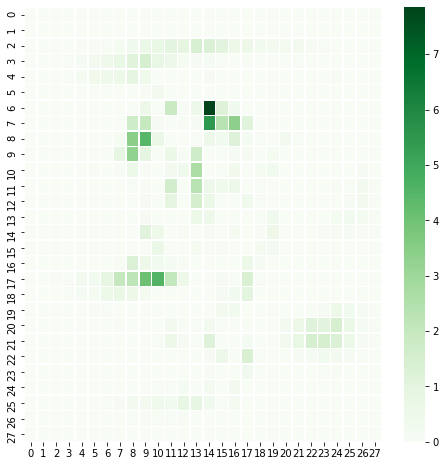

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 8)
ax = sns.heatmap(tf.reshape(cs_map, (h,w)), linewidth=0.5, cmap="Greens")
plt.show()
mpl.rcParams['figure.figsize'] = (4, 4)


In [ ]:
sum_s_top = compute_sensitive_score(image, correct_inx, masked_top)
sum_s_bottom = compute_sensitive_score(image, correct_inx, masked_bottom)

print(sum_s_top)
print(sum_s_bottom)

tf.Tensor(87.7374, shape=(), dtype=float32)
tf.Tensor(56.72408, shape=(), dtype=float32)


In [ ]:
num_images = []
for i in range(10):
  for j in range(200):
    inx = y_test[j]
    if (inx == i):
      num_images.append(x_test[j])
      break

Number: 0 
 S Score: 62.090999603271484
 S Score Top: 26.03719711303711
 S Score Bottom: 36.05380630493164


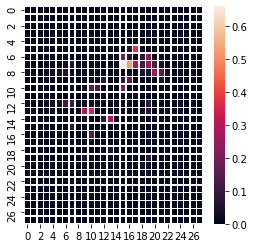

Number: 1 
 S Score: 48.46404266357422
 S Score Top: 17.419816970825195
 S Score Bottom: 31.04422950744629


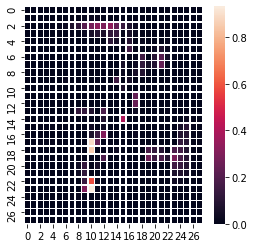

Number: 2 
 S Score: 47.30767059326172
 S Score Top: 17.37774658203125
 S Score Bottom: 29.929912567138672


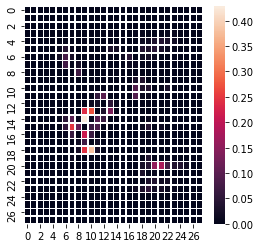

Number: 3 
 S Score: 87.27850341796875
 S Score Top: 66.34027862548828
 S Score Bottom: 20.938261032104492


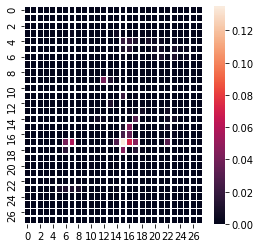

Number: 4 
 S Score: 95.8396224975586
 S Score Top: 52.93378829956055
 S Score Bottom: 42.90584945678711


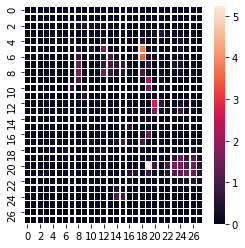

Number: 5 
 S Score: 97.91686248779297
 S Score Top: 50.18333053588867
 S Score Bottom: 47.73354721069336


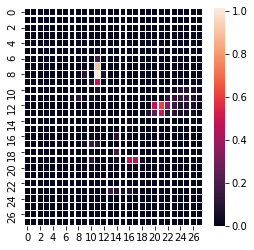

Number: 6 
 S Score: 90.44145965576172
 S Score Top: 74.66527557373047
 S Score Bottom: 15.77617073059082


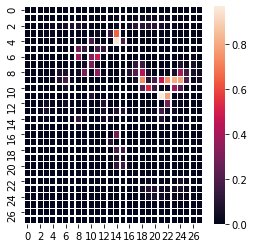

Number: 7 
 S Score: 84.4727554321289
 S Score Top: 27.816680908203125
 S Score Bottom: 56.656028747558594


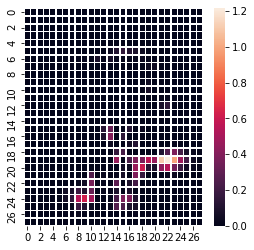

Number: 8 
 S Score: 78.61834716796875
 S Score Top: 17.403621673583984
 S Score Bottom: 61.21470260620117


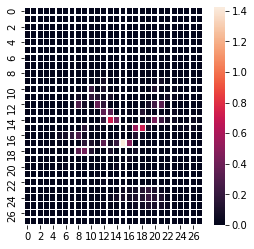

Number: 9 
 S Score: 91.6263427734375
 S Score Top: 59.163997650146484
 S Score Bottom: 32.462364196777344


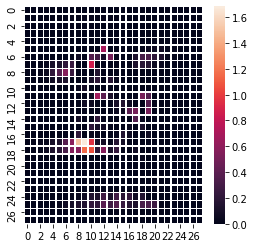

In [ ]:
for i in range(10):
  tmp_image = num_images[i]
  s_full = compute_sensitive_score(tmp_image, i)
  s_top = compute_sensitive_score(tmp_image, i, masked_top)
  s_bottom = compute_sensitive_score(tmp_image, i, masked_bottom)
  s = jacobian_map(tf.reshape(tmp_image,(1,h,w,ch)))
  c_map = compute_clipped_map(tmp_image, s[i], 1, 0)
  os_map = compute_other_s_map(s, correct_inx)
  s_map = s[i]
  cs_map = compute_cs_map(s_map, c_map, os_map)
  ax = sns.heatmap(tf.reshape(cs_map, (h,w,ch)), linewidth=0.5)
  print('Number: {} \n S Score: {}\n S Score Top: {}\n S Score Bottom: {}'.format(i, s_full, s_top, s_bottom))
  plt.show()

In [ ]:
mean_s_full = [0,0,0,0,0,0,0,0,0,0]
mean_s_top = [0,0,0,0,0,0,0,0,0,0]
mean_s_bottom = [0,0,0,0,0,0,0,0,0,0]
num_count = [0, 0 ,0 ,0 ,0 ,0,0,0,0,0]
for i in range(200):
  print('{}/200'.format(i+1))
  num = y_test[i]    
  tmp_image = x_test[i]
  tmp_image = tf.reshape(tmp_image, (1,h,w,ch))
  pred, _ = get_class_confidence(tmp_image)
  if(pred == num):
    num_count[num] += 1    
    s_full = compute_sensitive_score(tmp_image, num)
    s_top = compute_sensitive_score(tmp_image, num, masked_top)
    s_bottom = compute_sensitive_score(tmp_image, num, masked_bottom)
    mean_s_full[num] += s_full
    mean_s_top[num] += s_top
    mean_s_bottom[num] += s_bottom

In [ ]:
mean_s_full = np.array(mean_s_full)
mean_s_top = np.array(mean_s_top)
mean_s_bottom = np.array(mean_s_bottom)
num_count = np.array(num_count)

mean_s_full = mean_s_full/num_count
mean_s_top = mean_s_top/num_count
mean_s_bottom = mean_s_bottom/num_count

In [ ]:
for i in range(10):
  print('Number: {}\nMean S Score: {}\nMean S Score Top: {}\nMean S Score Bottom: {}'.format(i
                                                                                             , mean_s_full[i]
                                                                                             , mean_s_top[i]
                                                                                             , mean_s_bottom[i]))

Number: 0
Mean S Score: 46.39769071691177
Mean S Score Top: 16.329182344324447
Mean S Score Bottom: 30.06851375804228
Number: 1
Mean S Score: 86.83172607421875
Mean S Score Top: 30.036849975585938
Mean S Score Bottom: 56.794873918805806
Number: 2
Mean S Score: 94.64952087402344
Mean S Score Top: 27.571073532104492
Mean S Score Bottom: 67.07843017578125
Number: 3
Mean S Score: 88.87550354003906
Mean S Score Top: 45.8162727355957
Mean S Score Bottom: 43.059234619140625
Number: 4
Mean S Score: 102.98270961216518
Mean S Score Top: 48.65934099469866
Mean S Score Bottom: 54.3233642578125
Number: 5
Mean S Score: 94.0779541015625
Mean S Score Top: 53.6187744140625
Mean S Score Bottom: 40.45918579101563
Number: 6
Mean S Score: 114.1563232421875
Mean S Score Top: 75.6452880859375
Mean S Score Bottom: 38.51101989746094
Number: 7
Mean S Score: 69.93089803059895
Mean S Score Top: 20.402666727701824
Mean S Score Bottom: 49.528218587239586
Number: 8
Mean S Score: 95.664990234375
Mean S Score Top: 38.

## Individual-image basis Accuracy

### FGSM and IGSM

In [ ]:
fgsm_correct = 0
igsm_correct = 0
cw_correct = 0
jsma_correct = 0

n_fgsm = 0
n_igsm = 0
n_cw = 0
n_jsma = 0

In [ ]:
epsilons_no_zero = epsilons[1:]
for i in range(200):
  print('{}/{}'.format(i+1,200))
  image = x_test[i]
  correct_class = y_test[i]
  pred, _ = get_class_confidence(image)
  if(correct_class != pred):
    continue
  label = tf.reshape(y_test_oh[i], (1,10))
  fgsm_eps_top = 0.55
  fgsm_eps_bottom = 0.55
  igsm_eps_top = 0.55
  igsm_eps_bottom = 0.55
#FGSM TOP
  for j, eps in enumerate(epsilons_no_zero):
    adv = fgsm(image,label,eps,masked_top)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      fgsm_eps_top = eps
      break
#IGSM TOP
  for j, eps in enumerate(epsilons_no_zero):
    adv = igsm(image,label,eps // 0.02,0.02, eps, masked_top)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      igsm_eps_top = eps
      break
#FGSM BOTTOM
  for j, eps in enumerate(epsilons_no_zero):
    adv = fgsm(image,label,eps,masked_bottom)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      fgsm_eps_bottom = eps
      break
#IGSM BOTTOM
  for j, eps in enumerate(epsilons_no_zero):
    adv = igsm(image,label,eps // 0.02,0.02, eps, masked_bottom)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      igsm_eps_bottom = eps
      break
  s_top = compute_sensitive_score(image, correct_class, masked_top)
  s_bottom = compute_sensitive_score(image, correct_class, masked_bottom)
  if ((fgsm_eps_top > fgsm_eps_bottom and s_top < s_bottom) or (fgsm_eps_top < fgsm_eps_bottom and s_top > s_bottom)):
    fgsm_correct += 1
    n_fgsm += 1
  elif (fgsm_eps_top != fgsm_eps_bottom):
    n_fgsm += 1
  if ((igsm_eps_top > igsm_eps_bottom and s_top < s_bottom) or (igsm_eps_top < igsm_eps_bottom and s_top > s_bottom)):
    igsm_correct += 1
    n_igsm += 1
  elif (igsm_eps_top != igsm_eps_bottom):
    n_igsm += 1

fgsm_acc = fgsm_correct/float(n_fgsm)
igsm_acc = igsm_correct/float(n_igsm)
print('Correct FGSM: {}\nAccuracy FGSM: {}\nCorrect IGSM: {}\nAccuracy IGSM: {}\n'.format(fgsm_correct,fgsm_acc*100,igsm_correct,igsm_acc*100))

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/

### CW Attack

In [ ]:
epsilons_no_zero = epsilons[1:]
for i in range(200):
  print('{}/{}'.format(i+1,200))
  image = x_test[i]
  correct_class = y_test[i]
  pred, _ = get_class_confidence(image)
  if(correct_class != pred):
    continue
  label = tf.reshape(y_test_oh[i], (1,10))
  cw_eps_top = 11
  cw_eps_bottom = 11
#CW TOP
  adv, eps, c = cw(image, correct_class, 50, 0.1, masked=masked_top)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= 10):
    cw_eps_top = eps
#CW BOTTOM
  adv, eps, c = cw(image, correct_class, 50, 0.1, masked=masked_bottom)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= 10):
    cw_eps_bottom = eps
  s_top = compute_sensitive_score(image, correct_class, masked_top)
  s_bottom = compute_sensitive_score(image, correct_class, masked_bottom)
  if ((cw_eps_top > cw_eps_bottom and s_top < s_bottom) or (cw_eps_top < cw_eps_bottom and s_top > s_bottom)):
    cw_correct += 1
    n_cw += 1
  elif (cw_eps_top != cw_eps_bottom):
    n_cw += 1  

cw_acc = cw_correct/float(n_cw)
print('Correct CW: {}\nAccuracy CW: {}'.format(cw_correct,cw_acc*100))

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/

### JSMA

In [ ]:
epsilons_no_zero = epsilons[1:]
for i in range(200):
  print('{}/{}'.format(i+1,200))
  image = x_test[i]
  correct_class = y_test[i]
  pred, _ = get_class_confidence(image)
  if(correct_class != pred):
    continue
  label = tf.reshape(y_test_oh[i], (1,10))
  jsma_eps_top = h*w*ch*0.05 + 1
  jsma_eps_bottom = h*w*ch*0.05 + 1
#JSMA TOP
  adv, eps = jsma(image,correct_class,80,0.5, masked=masked_top)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= h*w*ch*0.05):
    jsma_eps_top = eps
#JSMA BOTTOM
  adv, eps = jsma(image,correct_class,80,0.5, masked=masked_bottom)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= h*w*ch*0.05):
    jsma_eps_bottom = eps
  s_top = compute_sensitive_score(image, correct_class, masked_top)
  s_bottom = compute_sensitive_score(image, correct_class, masked_bottom)
  if ((jsma_eps_top > jsma_eps_bottom and s_top < s_bottom) or (jsma_eps_top < jsma_eps_bottom and s_top > s_bottom)):
    jsma_correct += 1
    n_jsma += 1
  elif (jsma_eps_top != jsma_eps_bottom):
    n_jsma += 1  

jsma_acc = jsma_correct/float(n_jsma)
print('Correct JSMA: {}\nAccuracy JSMA: {}'.format(jsma_correct,jsma_acc*100))

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/